In [1]:
!pip install -U transformers datasets evaluate accelerate sentencepiece scikit-learn joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 91.5 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 102.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.1
    Uninstalling transformers-4.57.1:
      Successfully uninstalled transformers-4.57.1
  Attempting uninstall: datasets
    Found existing installation: datasets 4.4.2
    Uninstalling datasets-4.4.2:
      Successfully uninstalled data

In [2]:
# =============================================================================
# Enhanced DeBERTa-v3 Pipeline with Stylometric Domain Architecture
# Integrates: DDD, EmailText value objects, proper deduplication, GroupKFold
# =============================================================================

import os
import re
import hashlib
import warnings
from typing import List, Dict, Optional, Tuple, Any
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import scipy.special
import evaluate
import shutil
import joblib
import json
from tqdm import tqdm

from datasets import Dataset, load_dataset
from transformers import (
    AutoTokenizer,
    AutoModel,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, precision_recall_fscore_support
)
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from bs4 import BeautifulSoup

warnings.filterwarnings("ignore")

# =============================================================================
# CONFIGURATION
# =============================================================================
BASE_DIR = "/kaggle/working/paper_artifacts_deberta_enhanced"
MODELS_DIR = f"{BASE_DIR}/models"
OUT_DIR = f"{BASE_DIR}/outputs"
FINAL_MODEL_DIR = f"{BASE_DIR}/final_inference_model"
CHECKPOINT_DIR = "/kaggle/working/deberta_checkpoints"
JOBLIB_DIR = f"{BASE_DIR}/joblib_artifacts"

for d in [BASE_DIR, MODELS_DIR, OUT_DIR, FINAL_MODEL_DIR, CHECKPOINT_DIR, JOBLIB_DIR]:
    os.makedirs(d, exist_ok=True)

MODEL_NAME = "microsoft/deberta-v3-base"
NUM_LABELS = 4
NUM_FOLDS = 5
RANDOM_SEED = 42
MAX_LEN = 512
EPOCHS = 4
TRAIN_BATCH = 8
EVAL_BATCH = 16
LR = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1
GRADIENT_ACCUMULATION = 2
EXTRA_DIM = 24

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
FP16 = torch.cuda.is_available()
TARGET_NAMES = ["AI Phishing", "Enron Ham", "Manual Spam", "Nigerian Scam"]

def set_seed(seed=RANDOM_SEED):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

# =============================================================================
# DOMAIN MODEL - Value Objects (from Stylometric)
# =============================================================================

@dataclass(frozen=True)
class EmailText:
    """Value object representing cleaned email text with validation."""
    content: str
    content_hash: str
    
    @classmethod
    def create(cls, raw_text: str) -> Optional['EmailText']:
        """Factory method with validation."""
        if not isinstance(raw_text, str) or len(raw_text.strip()) < 10:
            return None
        
        cleaned = TextNormalizer.normalize(raw_text)
        if not cls._is_valid(cleaned):
            return None
            
        return cls(
            content=cleaned,
            content_hash=hashlib.sha256(cleaned.encode()).hexdigest()
        )
    
    @staticmethod
    def _is_valid(text: str) -> bool:
        """Quality validation."""
        if len(text) < 10 or len(text) > 10000:
            return False
        alpha_ratio = sum(c.isalpha() for c in text) / max(1, len(text))
        return alpha_ratio >= 0.1


# =============================================================================
# DOMAIN SERVICES - Text Processing (Enhanced from Stylometric)
# =============================================================================

class TextNormalizer:
    """Service for text normalization with entity replacement."""
    
    URL_RE = re.compile(r'https?://\S+|www\.\S+', flags=re.IGNORECASE)
    EMAIL_RE = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b')
    PHONE_RE = re.compile(r'\+?\d[\d\-\s]{6,}\d')
    
    @classmethod
    def normalize(cls, text: str) -> str:
        """Enhanced normalization with entity masking."""
        if not isinstance(text, str):
            return ""
        
        # Entity replacement (preserves semantic meaning while normalizing)
        text = cls.URL_RE.sub(" [URL] ", text)
        text = cls.EMAIL_RE.sub(" [EMAIL] ", text)
        text = cls.PHONE_RE.sub(" [PHONE] ", text)
        text = re.sub(r'\d{10,}', '[NUMBER]', text)
        text = re.sub(r'\$\d+(?:,\d{3})*(?:\.\d{2})?', '[MONEY]', text)
        
        # Whitespace normalization
        text = re.sub(r'\s+', ' ', text).strip()
        return text


class PhishingLexicon:
    """Domain service managing phishing-specific vocabulary."""
    
    IMPERATIVES = frozenset([
        "verify", "confirm", "update", "click", "respond", "login",
        "transfer", "act", "download", "open", "validate", "check",
        "reactivate", "restore", "unlock", "accept", "submit", "review"
    ])
    
    URGENCY_MARKERS = frozenset([
        "urgent", "immediately", "now", "asap", "expire", "expires",
        "suspension", "suspended", "limited", "deadline", "final",
        "warning", "alert", "action required", "time sensitive"
    ])
    
    FINANCIAL_TERMS = frozenset([
        "account", "bank", "card", "credit", "debit", "payment",
        "transaction", "money", "fund", "transfer", "refund",
        "owed", "debt", "paypal", "invoice", "billing"
    ])
    
    SCAM_KEYWORDS = [
        "inheritance", "beneficiary", "fund transfer", "million",
        "attorney", "diplomat", "widow", "lottery", "barrister",
        "deceased", "contract", "compensation", "unclaimed"
    ]
    
    @classmethod
    def compute_scam_score(cls, text: str) -> int:
        """Calculate Nigerian scam likelihood."""
        text_lower = text.lower()
        return sum(1 for kw in cls.SCAM_KEYWORDS if kw in text_lower)


# =============================================================================
# ENHANCED FEATURE EXTRACTORS (Improved from DeBERTa)
# =============================================================================

class EnhancedHeaderFeatureExtractor:
    """Extracts 10 sophisticated features from email headers."""
    
    DOMAIN_REGEX = re.compile(r'[\w\.-]+@([\w\.-]+)')
    SUSPICIOUS_TLDS = {'.xyz', '.top', '.ru', '.tk', '.info', '.club', '.cc', '.pw', '.work'}
    LEGITIMATE_DOMAINS = {'microsoft.com', 'google.com', 'slack.com', 'dropbox.com', 
                         'github.com', 'apple.com', 'amazon.com'}
    
    def _extract_from_domain(self, header: str) -> str:
        """Extract domain from 'From:' field."""
        match = re.search(r'From:.*?@([\w\.-]+)', header, re.IGNORECASE)
        return match.group(1).lower() if match else ""
    
    def _extract_to_domain(self, header: str) -> str:
        """Extract domain from 'To:' field."""
        match = re.search(r'To:.*?@([\w\.-]+)', header, re.IGNORECASE)
        return match.group(1).lower() if match else ""
    
    def _check_domain_spoofing(self, domain: str) -> int:
        """Detect common spoofing patterns."""
        if not domain:
            return 0
        
        spoofing_patterns = [
            (r'micr0soft', 'microsoft'),
            (r'g00gle', 'google'),
            (r'goog1e', 'google'),
            (r'app1e', 'apple'),
            (r'amaz0n', 'amazon'),
            (r'paypa1', 'paypal'),
        ]
        
        for pattern, _ in spoofing_patterns:
            if re.search(pattern, domain):
                return 1
        
        if domain.count('-') >= 3:
            return 1
        
        return 0
    
    def _compute_levenshtein(self, s1: str, s2: str) -> int:
        """Compute Levenshtein distance."""
        if len(s1) < len(s2):
            return self._compute_levenshtein(s2, s1)
        if len(s2) == 0:
            return len(s1)
        
        previous_row = range(len(s2) + 1)
        for i, c1 in enumerate(s1):
            current_row = [i + 1]
            for j, c2 in enumerate(s2):
                insertions = previous_row[j + 1] + 1
                deletions = current_row[j] + 1
                substitutions = previous_row[j] + (c1 != c2)
                current_row.append(min(insertions, deletions, substitutions))
            previous_row = current_row
        
        return previous_row[-1]
    
    def _check_domain_similarity(self, domain: str) -> float:
        """Check if domain is similar to legitimate domains (typosquatting)."""
        if not domain:
            return 0.0
        
        min_distance = float('inf')
        for legit in self.LEGITIMATE_DOMAINS:
            domain_base = domain.split('.')[0] if '.' in domain else domain
            legit_base = legit.split('.')[0]
            
            distance = self._compute_levenshtein(domain_base, legit_base)
            min_distance = min(min_distance, distance)
        
        return 1.0 if 1 <= min_distance <= 3 else 0.0
    
    def extract(self, header: str) -> List[float]:
        """Extract 10 header-based features."""
        header = header or ""
        
        # 1. Hop count
        hop_count = header.lower().count("received:")
        
        # 2-3. Authentication
        has_dkim = 1 if "dkim" in header.lower() else 0
        has_spf = 1 if "spf" in header.lower() else 0
        
        # 4-5. Domain analysis
        domains = self.DOMAIN_REGEX.findall(header)
        suspicious_tld = 0
        for d in domains:
            if any(d.endswith(tld) for tld in self.SUSPICIOUS_TLDS):
                suspicious_tld = 1
                break
        
        unique_domains = len(set(domains))
        
        # 6. From-To mismatch
        from_domain = self._extract_from_domain(header)
        to_domain = self._extract_to_domain(header)
        domain_mismatch = 0
        if from_domain and to_domain and from_domain != to_domain:
            domain_mismatch = 1
        
        # 7-8. Spoofing detection
        spoofing = self._check_domain_spoofing(from_domain)
        typosquatting = self._check_domain_similarity(from_domain)
        
        # 9. Urgency in subject
        subject_match = re.search(r'(?i)^Subject:\s*(.+)$', header, re.MULTILINE)
        subject = subject_match.group(1).lower() if subject_match else ""
        urgency_keywords = ['urgent', 'immediate', 'action required', 'expires', 
                           'within', 'hours', 'verify', 'suspend', 'alert']
        urgency_score = sum(1 for keyword in urgency_keywords if keyword in subject)
        urgency_score = min(urgency_score, 5) / 5.0
        
        # 10. Authentication headers
        auth_headers = sum([
            1 if 'authentication-results:' in header.lower() else 0,
            1 if 'dkim-signature:' in header.lower() else 0,
            1 if 'arc-authentication-results:' in header.lower() else 0
        ])
        
        return [
            float(min(hop_count, 10)) / 10.0,
            float(has_dkim),
            float(has_spf),
            float(suspicious_tld),
            float(min(unique_domains, 10)) / 10.0,
            float(domain_mismatch),
            float(spoofing),
            float(typosquatting),
            float(urgency_score),
            float(auth_headers) / 3.0
        ]


class EnhancedHtmlFeatureExtractor:
    """Extracts 8 features from HTML content."""
    
    def _extract_urls(self, html: str) -> List[str]:
        """Extract all URLs from HTML."""
        try:
            soup = BeautifulSoup(html, "html.parser")
            links = soup.find_all("a")
            return [a.get("href", "") for a in links if a.get("href")]
        except Exception:
            return []
    
    def _check_url_mismatch(self, anchor_text: str, href: str) -> bool:
        """Check if anchor text suggests different URL than href."""
        if not anchor_text or not href:
            return False
        
        services = ['dropbox', 'google', 'microsoft', 'slack', 'github', 
                   'apple', 'amazon', 'paypal']
        
        anchor_lower = anchor_text.lower()
        href_lower = href.lower()
        
        for service in services:
            if service in anchor_lower and service not in href_lower:
                return True
        
        return False
    
    def extract(self, html: str) -> List[float]:
        """Extract 8 HTML-based features."""
        html = html or ""
        if not html.strip():
            return [0.0] * 8
        
        try:
            soup = BeautifulSoup(html, "html.parser")
        except Exception:
            return [0.0] * 8
        
        # 1-2. Links analysis
        links = soup.find_all("a")
        total_links = len(links)
        
        external_count = sum(1 for a in links 
                           if a.get("href", "").startswith(("http://", "https://")))
        external_ratio = external_count / max(total_links, 1)
        
        # 3. Mismatched anchor text
        mismatch_count = sum(1 for a in links 
                           if self._check_url_mismatch((a.text or "").strip(), a.get("href", "")))
        
        # 4. Hidden elements
        hidden_count = sum(1 for elem in soup.find_all(style=True)
                         if any(x in elem.get("style", "").lower() 
                               for x in ["display:none", "display: none", 
                                        "visibility:hidden", "visibility: hidden"]))
        
        # 5-6. Forms and scripts
        forms_count = len(soup.find_all("form"))
        scripts = soup.find_all("script")
        inline_scripts = sum(1 for s in scripts if not s.get("src"))
        
        # 7. Obfuscated URLs
        urls = self._extract_urls(html)
        obfuscated_count = sum(1 for url in urls 
                             if (re.search(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', url) or
                                 ('%' in url and re.search(r'%[0-9A-Fa-f]{2}', url))))
        
        # 8. Style deception
        style_deception = sum(1 for elem in soup.find_all(style=True)
                            if any(x in elem.get("style", "").lower() 
                                  for x in ['font-size:0', 'font-size:1', 'font-size:2',
                                           'color:#fff', 'color:white']))
        
        return [
            float(min(total_links, 20)) / 20.0,
            float(external_ratio),
            float(min(mismatch_count, 10)) / 10.0,
            float(min(hidden_count, 10)) / 10.0,
            float(min(forms_count, 5)) / 5.0,
            float(min(inline_scripts, 5)) / 5.0,
            float(min(obfuscated_count, 10)) / 10.0,
            float(min(style_deception, 5)) / 5.0
        ]


class EnhancedAttachmentFeatureExtractor:
    """Extracts 6 features from attachments."""
    
    SUSPICIOUS_EXT = {
        '.exe', '.js', '.bat', '.scr', '.ps1', '.vbs', '.jar',
        '.zip', '.rar', '.7z', '.html', '.htm', '.hta',
        '.docm', '.xlsm', '.pptm', '.pdf', '.iso'
    }
    
    def _compute_entropy(self, s: str) -> float:
        """Calculate Shannon entropy."""
        if not s:
            return 0.0
        from math import log2
        probs = [s.count(c) / len(s) for c in set(s)]
        return -sum(p * log2(p) for p in probs if p > 0)
    
    def _parse_attachments(self, raw: str) -> List[Dict]:
        """Parse attachment JSON string."""
        if not raw:
            return []
        try:
            attachments = json.loads(raw) if isinstance(raw, str) else raw
            return attachments if isinstance(attachments, list) else []
        except Exception:
            return []
    
    def extract(self, raw: str) -> List[float]:
        """Extract 6 attachment-based features."""
        attachments = self._parse_attachments(raw)
        
        if not attachments:
            return [0.0] * 6
        
        count = len(attachments)
        suspicious_ext = 0
        missing_metadata = 0
        entropy_sum = 0.0
        total_size = 0
        mime_mismatch = 0
        
        for att in attachments:
            if not isinstance(att, dict):
                continue
            
            filename = att.get("filename")
            mime = att.get("mime")
            size = att.get("size")
            
            if filename is None:
                missing_metadata += 1
            else:
                ext = os.path.splitext(str(filename))[1].lower()
                if ext in self.SUSPICIOUS_EXT:
                    suspicious_ext += 1
                
                entropy_sum += self._compute_entropy(str(filename))
                
                if mime:
                    if ext == '.pdf' and 'pdf' not in str(mime).lower():
                        mime_mismatch += 1
                    elif ext in {'.jpg', '.jpeg', '.png', '.gif'} and 'image' not in str(mime).lower():
                        mime_mismatch += 1
            
            if mime is None:
                missing_metadata += 1
            
            if size:
                try:
                    total_size += int(size)
                except Exception:
                    pass
        
        return [
            float(min(count, 10)) / 10.0,
            float(suspicious_ext) / max(count, 1),
            float(missing_metadata) / (count * 2),
            float(entropy_sum) / max(count, 1),
            float(min(total_size, 10_000_000)) / 10_000_000,
            float(min(mime_mismatch, 5)) / 5.0
        ]


# Initialize extractors
HEADER_EX = EnhancedHeaderFeatureExtractor()
HTML_EX = EnhancedHtmlFeatureExtractor()
ATT_EX = EnhancedAttachmentFeatureExtractor()


def assemble_extra_features(row: Dict[str, Any]) -> List[float]:
    """Assemble all 24 features."""
    header = row.get("headers") or row.get("header") or ""
    html = row.get("html") or row.get("html_body") or ""
    attachments = row.get("attachments") or row.get("attachment") or ""
    
    h_feats = HEADER_EX.extract(header)
    html_feats = HTML_EX.extract(html)
    att_feats = ATT_EX.extract(attachments)
    
    feats = h_feats + html_feats + att_feats
    
    if len(feats) < EXTRA_DIM:
        feats = feats + [0.0] * (EXTRA_DIM - len(feats))
    
    return feats[:EXTRA_DIM]


# =============================================================================
# DATA LOADING WITH DOMAIN-DRIVEN DEDUPLICATION
# =============================================================================

class BalancedDatasetBuilder:
    """
    Enhanced dataset builder using EmailText value objects and proper deduplication.
    Strategy: Keep ALL data, use class weights, remove only duplicates.
    """
    
    TARGET_NAMES = TARGET_NAMES
    
    def __init__(self, random_seed: int = 42):
        self.random_seed = random_seed
    
    def build(self, ai_csv_path: str) -> pd.DataFrame:
        """Build dataset with proper deduplication and quality checks."""
        print("\n" + "="*70)
        print("BUILDING DATASET WITH ENHANCED PREPROCESSING")
        print("="*70)
        
        # Load AI emails
        ai_df = self._process_ai_emails(ai_csv_path)
        
        # Load Enron
        from datasets import load_dataset
        enron = load_dataset("SetFit/enron_spam", split="train").to_pandas()
        
        ham_all = enron[enron.label == 0][["text"]].copy()
        spam_all = enron[enron.label == 1][["text"]].copy()
        
        # Classify spam subtypes
        spam_all["scam_score"] = spam_all["text"].apply(PhishingLexicon.compute_scam_score)
        nigerian_df = spam_all[spam_all.scam_score >= 3][["text"]].copy()
        manual_spam_df = spam_all[spam_all.scam_score < 3][["text"]].copy()
        
        print(f"\nRaw counts:")
        print(f"  AI Phishing: {len(ai_df)}")
        print(f"  Enron Ham: {len(ham_all)}")
        print(f"  Manual Spam: {len(manual_spam_df)}")
        print(f"  Nigerian Scam: {len(nigerian_df)}")
        
        # Clean and deduplicate each class using EmailText value objects
        datasets = {
            0: self._clean_and_dedup(ai_df, has_metadata=True),
            1: self._clean_and_dedup(ham_all, has_metadata=False),
            2: self._clean_and_dedup(manual_spam_df, has_metadata=False),
            3: self._clean_and_dedup(nigerian_df, has_metadata=False)
        }
        
        print(f"\nAfter cleaning & deduplication:")
        for label, df in datasets.items():
            print(f"  {self.TARGET_NAMES[label]}: {len(df)}")
        
        # Smart balancing (reasonable cap, not aggressive downsampling)
        max_samples_per_class = 2000
        
        balanced_parts = []
        for label, df in datasets.items():
            df["label"] = label
            
            if len(df) > max_samples_per_class:
                sampled = df.sample(n=max_samples_per_class, random_state=self.random_seed)
                print(f"  ⚠ {self.TARGET_NAMES[label]}: Capped at {max_samples_per_class}")
            else:
                sampled = df
            
            balanced_parts.append(sampled)
        
        # Combine
        df_final = pd.concat(balanced_parts, ignore_index=True)
        df_final = df_final.sample(frac=1.0, random_state=self.random_seed).reset_index(drop=True)
        
        # Global deduplication
        before = len(df_final)
        df_final = df_final.drop_duplicates("text", keep='first')
        after = len(df_final)
        
        if before > after:
            print(f"\n✓ Removed {before - after} global duplicates")
        
        print(f"\n{'='*70}")
        print("FINAL DATASET STATISTICS")
        print(f"{'='*70}")
        print(f"Total samples: {len(df_final)}")
        print(f"\nClass distribution:")
        class_dist = df_final["label"].value_counts().sort_index()
        for label, count in class_dist.items():
            print(f"  {label} - {self.TARGET_NAMES[label]}: {count}")
        
        # Compute class weights
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(df_final["label"]),
            y=df_final["label"]
        )
        print(f"\nClass weights (for training):")
        for label, weight in enumerate(class_weights):
            print(f"  {self.TARGET_NAMES[label]}: {weight:.3f}")
        
        return df_final
    
    def _process_ai_emails(self, csv_path: str) -> pd.DataFrame:
        """Process AI emails with metadata extraction."""
        try:
            df = pd.read_csv(csv_path)
            print(f"✓ Loaded {len(df)} AI emails")
        except FileNotFoundError:
            print("⚠ AI emails CSV not found. Using dummy data.")
            df = pd.DataFrame({
                "plain": [f"Test phishing {i}" for i in range(100)],
                "headers": [f"Subject: Urgent {i}\nFrom: test@example.com" for i in range(100)],
                "html": ["<html><body>Test</body></html>" for _ in range(100)],
                "attachments": ["[]" for _ in range(100)]
            })
        
        # Flexible column handling
        if "headers" not in df.columns and "header" in df.columns:
            df = df.rename(columns={"header": "headers"})
        if "plain" not in df.columns and "text" in df.columns:
            df = df.rename(columns={"text": "plain"})
        
        # Fill missing values
        for col in ["headers", "plain", "html", "attachments"]:
            if col not in df.columns:
                df[col] = ""
            else:
                df[col] = df[col].fillna("")
        
        # Extract subject
        df["subject"] = df["headers"].apply(lambda h: 
            re.search(r'(?i)^Subject:\s*(.+)$', str(h), re.MULTILINE).group(1).strip()
            if re.search(r'(?i)^Subject:\s*(.+)$', str(h), re.MULTILINE) else ""
        )
        
        # Combine subject + body
        df["text"] = ("Subject: " + df["subject"] + "\n" + df["plain"]).str.strip()
        
        return df[["text", "headers", "html", "attachments"]]
    
    def _clean_and_dedup(self, df: pd.DataFrame, has_metadata: bool = False) -> pd.DataFrame:
        """Clean text using EmailText value objects and remove duplicates."""
        df = df.copy()
        
        # Create EmailText value objects for validation
        valid_emails = [EmailText.create(t) for t in df["text"]]
        df["email_obj"] = valid_emails
        df = df[df["email_obj"].notna()].copy()
        df["text"] = df["email_obj"].apply(lambda e: e.content)
        
        # Extract features if metadata available
        if has_metadata:
            feat_list = []
            for _, row in df.iterrows():
                feat_list.append(assemble_extra_features(row))
            df["features"] = feat_list
        else:
            # Enron data has no metadata
            df["features"] = [[0.0] * EXTRA_DIM for _ in range(len(df))]
            df["headers"] = ""
            df["html"] = ""
            df["attachments"] = ""
        
        # Deduplicate
        df = df.drop_duplicates("text")
        
        # Ensure all required columns
        for col in ["headers", "html", "attachments"]:
            if col not in df.columns:
                df[col] = ""
        
        return df.drop(columns=["email_obj"]).reset_index(drop=True)


# =============================================================================
# BUILD DATASET
# =============================================================================
builder = BalancedDatasetBuilder(random_seed=RANDOM_SEED)
df = builder.build(ai_csv_path="/kaggle/input/ai-emails/ai_emails.csv")

dataset_info = {
    "total_samples": len(df),
    "class_distribution": df["label"].value_counts().sort_index().to_dict(),
    "unique_texts": df["text"].nunique(),
    "avg_text_length": float(df["text"].str.len().mean()),
    "target_names": TARGET_NAMES,
    "extra_feature_dim": EXTRA_DIM,
    "timestamp": datetime.now().isoformat(),
    "preprocessing": "enhanced_with_emailtext_value_objects"
}

with open(f"{OUT_DIR}/dataset_info.json", "w") as f:
    json.dump(dataset_info, f, indent=4)


# =============================================================================
# GROUPKFOLD CROSS-VALIDATION (from Stylometric)
# =============================================================================

class GroupedCrossValidator:
    """Cross-validation using GroupKFold to prevent leakage."""
    
    def __init__(self, n_splits: int = 5):
        self.n_splits = n_splits
        self.gkf = GroupKFold(n_splits=n_splits)
    
    def create_groups(self, texts: np.ndarray) -> np.ndarray:
        """Create groups based on content hash."""
        groups = np.array([hashlib.sha256(str(text).encode()).hexdigest()[:8] 
                          for text in texts])
        return groups
    
    def split(self, X: np.ndarray, y: np.ndarray) -> List[Tuple[np.ndarray, np.ndarray]]:
        """Generate train/val splits grouped by content hash."""
        groups = self.create_groups(X)
        splits = list(self.gkf.split(X, y, groups=groups))
        
        print(f"\n✓ Created {len(splits)} GroupKFold splits")
        print(f"  Unique groups: {len(np.unique(groups))}")
        
        return splits


# =============================================================================
# TRAIN/TEST SPLIT WITH STRATIFICATION
# =============================================================================
print(f"\n{'='*70}")
print("Creating Stratified Train/Test Split")
print(f"{'='*70}")

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=RANDOM_SEED
)

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print(f"\nTest set class distribution:")
test_dist = test_df["label"].value_counts().sort_index()
for label, count in test_dist.items():
    print(f"  {TARGET_NAMES[label]}: {count}")

# Save test set
test_df.to_csv(f"{OUT_DIR}/holdout_clean.csv", index=False)
print(f"✓ Saved test set to {OUT_DIR}/holdout_clean.csv")


# =============================================================================
# TOKENIZER & CUSTOM DATA COLLATOR
# =============================================================================
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)


def data_collator_hybrid(features: List[Dict[str, Any]]):
    """Custom collator that handles both text tokens and extra features."""
    batch_text = [
        {"input_ids": f["input_ids"], "attention_mask": f["attention_mask"]}
        for f in features
    ]
    
    # Pad text tokens
    batch = tokenizer.pad(batch_text, return_tensors="pt")
    
    # Stack extra features
    extra = [f.get("extra_features", [0.0] * EXTRA_DIM) for f in features]
    batch["extra_features"] = torch.tensor(extra, dtype=torch.float32)
    
    # Add labels if present
    if "label" in features[0]:
        batch["labels"] = torch.tensor([f["label"] for f in features], dtype=torch.long)
    
    return batch


# =============================================================================
# HYBRID MODEL ARCHITECTURE
# =============================================================================

class DebertaHybridModel(nn.Module):
    """
    Hybrid model combining DeBERTa text encoder with extra email features.
    
    Architecture:
    - DeBERTa encoder for text (768-dim CLS token)
    - Extra features (24-dim) from headers/HTML/attachments
    - Combined through MLP (768+24 -> 512 -> 128 -> 4 classes)
    """
    
    def __init__(self, model_name: str, num_labels: int, extra_dim: int):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden = self.encoder.config.hidden_size
        
        self.mlp = nn.Sequential(
            nn.Linear(hidden + extra_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_labels)
        )
    
    def forward(self, input_ids=None, attention_mask=None, extra_features=None, labels=None):
        # Encode text
        out = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        
        # Get pooled output (CLS token)
        if hasattr(out, "pooler_output") and out.pooler_output is not None:
            pooled = out.pooler_output
        else:
            pooled = out.last_hidden_state[:, 0]
        
        # Handle missing extra features
        if extra_features is None:
            extra_features = torch.zeros((pooled.size(0), EXTRA_DIM), device=pooled.device)
        
        # Concatenate text and extra features
        x = torch.cat([pooled, extra_features], dim=1)
        
        # Classify
        logits = self.mlp(x)
        
        # Compute loss if labels provided
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
            return {"loss": loss, "logits": logits}
        
        return {"logits": logits}


# =============================================================================
# PREPROCESSING FOR HUGGINGFACE DATASETS
# =============================================================================

def hf_preprocess_map(batch):
    """Preprocess batch for HuggingFace dataset."""
    enc = tokenizer(batch["text"], truncation=True, max_length=MAX_LEN)
    return {
        "input_ids": enc["input_ids"],
        "attention_mask": enc["attention_mask"],
        "extra_features": batch["features"],
        "label": batch["label"]
    }


# =============================================================================
# CROSS-VALIDATION TRAINING WITH GROUPKFOLD
# =============================================================================

# Initialize cross-validator
cv = GroupedCrossValidator(n_splits=NUM_FOLDS)

# Storage for predictions
test_fold_preds = np.zeros((len(test_df), NUM_LABELS, NUM_FOLDS))
best_f1 = 0.0
best_fold_idx = 0
fold_metrics = []

# Prepare test dataset once
hf_test = Dataset.from_pandas(test_df.reset_index(drop=True)).map(
    hf_preprocess_map,
    batched=True,
    remove_columns=test_df.columns.tolist()
)

print(f"\n{'='*70}")
print(f"STARTING {NUM_FOLDS}-FOLD CROSS-VALIDATION WITH GROUPKFOLD")
print(f"{'='*70}")

# Get GroupKFold splits
splits = cv.split(train_df["text"].values, train_df["label"].values)

for fold, (tr_idx, va_idx) in enumerate(splits):
    print(f"\n{'='*70}")
    print(f"Fold {fold+1}/{NUM_FOLDS}")
    print(f"{'='*70}")
    
    fold_train = train_df.iloc[tr_idx].reset_index(drop=True)
    fold_val = train_df.iloc[va_idx].reset_index(drop=True)
    
    print(f"Train: {len(fold_train)} | Validation: {len(fold_val)}")
    print(f"\nTrain class distribution:")
    print(fold_train["label"].value_counts().sort_index())
    print(f"\nValidation class distribution:")
    print(fold_val["label"].value_counts().sort_index())
    
    # Compute class weights for this fold
    class_weights_dict = {}
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(fold_train["label"]),
        y=fold_train["label"]
    )
    for i, weight in enumerate(class_weights):
        class_weights_dict[i] = weight
    
    print(f"\nClass weights for fold {fold+1}:")
    for label, weight in class_weights_dict.items():
        print(f"  {TARGET_NAMES[label]}: {weight:.3f}")
    
    # Create datasets
    ds_train = Dataset.from_pandas(fold_train).map(
        hf_preprocess_map,
        batched=True,
        remove_columns=fold_train.columns.tolist()
    )
    
    ds_val = Dataset.from_pandas(fold_val).map(
        hf_preprocess_map,
        batched=True,
        remove_columns=fold_val.columns.tolist()
    )
    
    # Initialize model
    print(f"\n{'='*60}")
    print("Initializing Hybrid Model")
    print(f"{'='*60}")
    model = DebertaHybridModel(MODEL_NAME, NUM_LABELS, EXTRA_DIM)
    model.to(DEVICE)
    
    print(f"✓ Model loaded on {DEVICE}")
    print(f"  DeBERTa encoder: {MODEL_NAME}")
    print(f"  Extra features: {EXTRA_DIM} dimensions")
    print(f"  Output classes: {NUM_LABELS}")
    
    # Training arguments
    args = TrainingArguments(
        output_dir=f"{CHECKPOINT_DIR}/fold_{fold}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=LR,
        per_device_train_batch_size=TRAIN_BATCH,
        per_device_eval_batch_size=EVAL_BATCH,
        num_train_epochs=EPOCHS,
        weight_decay=WEIGHT_DECAY,
        warmup_ratio=WARMUP_RATIO,
        gradient_accumulation_steps=GRADIENT_ACCUMULATION,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        fp16=FP16,
        report_to="none",
        save_total_limit=1,
        logging_steps=50,
        seed=RANDOM_SEED,
        dataloader_num_workers=0,
        remove_unused_columns=False
    )
    
    # Metrics
    f1_metric = evaluate.load("f1")
    acc_metric = evaluate.load("accuracy")
    
    def compute_metrics_train(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        return {
            "accuracy": acc_metric.compute(predictions=preds, references=labels)["accuracy"],
            "f1_macro": f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"],
            "f1_weighted": f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
        }
    
    # Trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=ds_train,
        eval_dataset=ds_val,
        tokenizer=tokenizer,
        data_collator=data_collator_hybrid,
        compute_metrics=compute_metrics_train,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )
    
    # Train
    print(f"\n{'='*60}")
    print("Training")
    print(f"{'='*60}")
    trainer.train()
    
    # Evaluate on validation set
    print(f"\n{'='*60}")
    print("Validation Evaluation")
    print(f"{'='*60}")
    metrics = trainer.evaluate()
    
    fold_metrics.append({
        'fold': fold,
        'accuracy': metrics.get('eval_accuracy', 0.0),
        'f1_macro': metrics.get('eval_f1_macro', 0.0),
        'f1_weighted': metrics.get('eval_f1_weighted', 0.0),
        'loss': metrics.get('eval_loss', 0.0)
    })
    
    print(f"\n✓ Fold {fold+1} Validation Results:")
    print(f"  Accuracy: {metrics.get('eval_accuracy', 0.0):.4f}")
    print(f"  F1 Macro: {metrics.get('eval_f1_macro', 0.0):.4f}")
    print(f"  F1 Weighted: {metrics.get('eval_f1_weighted', 0.0):.4f}")
    print(f"  Loss: {metrics.get('eval_loss', 0.0):.4f}")
    
    # Track best model
    if metrics.get("eval_f1_macro", 0.0) > best_f1:
        best_f1 = metrics.get("eval_f1_macro", 0.0)
        best_fold_idx = fold
        print(f"  ✓ New best model! (F1: {best_f1:.4f})")
    
    # Predict on test set
    print(f"\n{'='*60}")
    print("Test Set Prediction")
    print(f"{'='*60}")
    test_pred = trainer.predict(hf_test)
    test_logits = test_pred.predictions
    test_fold_preds[:, :, fold] = scipy.special.softmax(test_logits, axis=1)
    print(f"✓ Test predictions stored for fold {fold+1}")
    
    # Save fold model
    fold_save_path = f"{MODELS_DIR}/fold_{fold}"
    trainer.save_model(fold_save_path)
    print(f"✓ Model saved to {fold_save_path}")
    
    # Cleanup
    del model, trainer, ds_train, ds_val
    torch.cuda.empty_cache()
    print(f"✓ Memory cleared")


# =============================================================================
# ENSEMBLE EVALUATION ON TEST SET
# =============================================================================

print(f"\n{'='*70}")
print("ENSEMBLE EVALUATION ON TEST SET")
print(f"{'='*70}")

# Average predictions across folds (soft voting)
avg_test_preds = test_fold_preds.mean(axis=2)
y_pred = np.argmax(avg_test_preds, axis=1)
y_true = test_df["label"].values

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
precision, recall, f1_per_class, support = precision_recall_fscore_support(
    y_true, y_pred, average=None, zero_division=0
)

print(f"\n✓ Ensemble Performance (Soft Voting):")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  F1 Macro: {f1_macro:.4f}")
print(f"  F1 Weighted: {f1_weighted:.4f}")

print(f"\nPer-class Performance:")
for i, name in enumerate(TARGET_NAMES):
    print(f"  {name}:")
    print(f"    Precision: {precision[i]:.4f}")
    print(f"    Recall: {recall[i]:.4f}")
    print(f"    F1: {f1_per_class[i]:.4f}")
    print(f"    Support: {support[i]}")

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print(f"\nConfusion Matrix:")
print(conf_matrix)

# Cross-validation summary
print(f"\n{'='*70}")
print("CROSS-VALIDATION SUMMARY")
print(f"{'='*70}")

fold_accs = [m["accuracy"] for m in fold_metrics]
fold_f1s = [m["f1_macro"] for m in fold_metrics]

print(f"Validation Accuracy: {np.mean(fold_accs):.4f} ± {np.std(fold_accs):.4f}")
print(f"Validation F1 Macro: {np.mean(fold_f1s):.4f} ± {np.std(fold_f1s):.4f}")

print(f"\nFold-wise metrics:")
for i, metrics in enumerate(fold_metrics):
    print(f"  Fold {i+1}: Acc={metrics['accuracy']:.4f}, F1={metrics['f1_macro']:.4f}")

print(f"\nBest fold: {best_fold_idx+1} (F1: {best_f1:.4f})")


# =============================================================================
# SAVE ARTIFACTS
# =============================================================================

print(f"\n{'='*70}")
print("SAVING ARTIFACTS")
print(f"{'='*70}")

# Classification report
report = classification_report(y_true, y_pred, target_names=TARGET_NAMES, digits=4)
with open(f"{OUT_DIR}/classification_report.txt", "w") as f:
    f.write("="*70 + "\n")
    f.write("ENSEMBLE CLASSIFICATION REPORT\n")
    f.write("="*70 + "\n\n")
    f.write(report)
    f.write("\n\n")
    f.write("Confusion Matrix:\n")
    f.write(str(conf_matrix))
    f.write("\n")

print("\n" + report)
print(f"✓ Saved classification report to {OUT_DIR}/classification_report.txt")

# Save numpy arrays
np.save(f"{OUT_DIR}/confusion_matrix.npy", conf_matrix)
np.save(f"{OUT_DIR}/X_test_texts.npy", test_df["text"].to_numpy())
np.save(f"{OUT_DIR}/y_test.npy", y_true)
np.save(f"{OUT_DIR}/y_pred.npy", y_pred)
np.save(f"{OUT_DIR}/test_probabilities.npy", avg_test_preds)
np.save(f"{OUT_DIR}/all_fold_predictions.npy", test_fold_preds)

print(f"✓ Saved test arrays to {OUT_DIR}")

# Joblib artifacts
print(f"\nSaving Joblib artifacts...")

label_encoder = LabelEncoder()
label_encoder.fit(TARGET_NAMES)
joblib.dump(label_encoder, f"{JOBLIB_DIR}/label_encoder.joblib")

metadata = {
    'target_names': TARGET_NAMES,
    'num_classes': NUM_LABELS,
    'extra_feature_dim': EXTRA_DIM,
    'test_accuracy': float(accuracy),
    'test_f1_macro': float(f1_macro),
    'test_f1_weighted': float(f1_weighted),
    'fold_metrics': fold_metrics,
    'best_fold': best_fold_idx,
    'best_fold_f1': float(best_f1),
    'cv_accuracy_mean': float(np.mean(fold_accs)),
    'cv_accuracy_std': float(np.std(fold_accs)),
    'cv_f1_mean': float(np.mean(fold_f1s)),
    'cv_f1_std': float(np.std(fold_f1s)),
    'confusion_matrix': conf_matrix.tolist(),
    'per_class_metrics': {
        TARGET_NAMES[i]: {
            'precision': float(precision[i]) if len(precision) > i else 0.0,
            'recall': float(recall[i]) if len(recall) > i else 0.0,
            'f1': float(f1_per_class[i]) if len(f1_per_class) > i else 0.0,
            'support': int(support[i]) if len(support) > i else 0
        } for i in range(NUM_LABELS)
    },
    'dataset_info': dataset_info,
    'preprocessing': 'enhanced_with_domain_driven_design',
    'cross_validation': 'GroupKFold',
    'timestamp': datetime.now().isoformat()
}
joblib.dump(metadata, f"{JOBLIB_DIR}/model_metadata.joblib")

training_config = {
    'model_name': MODEL_NAME,
    'max_len': MAX_LEN,
    'batch_size': TRAIN_BATCH,
    'eval_batch_size': EVAL_BATCH,
    'epochs': EPOCHS,
    'learning_rate': LR,
    'weight_decay': WEIGHT_DECAY,
    'warmup_ratio': WARMUP_RATIO,
    'gradient_accumulation': GRADIENT_ACCUMULATION,
    'num_folds': NUM_FOLDS,
    'seed': RANDOM_SEED,
    'device': DEVICE,
    'fp16': FP16,
    'extra_feature_dim': EXTRA_DIM
}
joblib.dump(training_config, f"{JOBLIB_DIR}/training_config.joblib")

tokenizer_config = {
    'tokenizer_name': MODEL_NAME,
    'max_length': MAX_LEN,
    'vocab_size': len(tokenizer)
}
joblib.dump(tokenizer_config, f"{JOBLIB_DIR}/tokenizer_config.joblib")

predictions_data = {
    'y_true': y_true,
    'y_pred': y_pred,
    'probabilities': avg_test_preds,
    'text_samples': test_df["text"].tolist(),
    'fold_predictions': test_fold_preds
}
joblib.dump(predictions_data, f"{JOBLIB_DIR}/predictions_data.joblib")

print(f"✓ Saved {len(os.listdir(JOBLIB_DIR))} joblib files to {JOBLIB_DIR}")

# Export best model for inference
print(f"\n{'='*60}")
print("Exporting Best Model for Inference")
print(f"{'='*60}")

best_model_path = f"{MODELS_DIR}/fold_{best_fold_idx}"
if os.path.exists(best_model_path):
    if os.path.exists(FINAL_MODEL_DIR):
        shutil.rmtree(FINAL_MODEL_DIR)
    shutil.copytree(best_model_path, FINAL_MODEL_DIR)
    print(f"✓ Copied best model (Fold {best_fold_idx+1}) to {FINAL_MODEL_DIR}")
else:
    print(f"⚠ Best model path not found, saving tokenizer only")
    tokenizer.save_pretrained(FINAL_MODEL_DIR)

# Save configuration JSON
config_data = {
    "model_name": MODEL_NAME,
    "labels_map": {i: name for i, name in enumerate(TARGET_NAMES)},
    "training_config": training_config,
    "ensemble_strategy": f"soft_voting_{NUM_FOLDS}_fold_groupkfold",
    "best_fold": best_fold_idx,
    "best_fold_f1": float(best_f1),
    "test_metrics": {
        "accuracy": float(accuracy),
        "f1_macro": float(f1_macro),
        "f1_weighted": float(f1_weighted)
    },
    "cross_validation_metrics": {
        "accuracy_mean": float(np.mean(fold_accs)),
        "accuracy_std": float(np.std(fold_accs)),
        "f1_macro_mean": float(np.mean(fold_f1s)),
        "f1_macro_std": float(np.std(fold_f1s))
    },
    "fold_metrics": fold_metrics,
    "dataset_info": dataset_info,
    "preprocessing_enhancements": [
        "EmailText value objects",
        "TextNormalizer with entity masking",
        "Two-pass deduplication",
        "GroupKFold cross-validation",
        "Class weight balancing"
    ],
    "timestamp": datetime.now().isoformat()
}

with open(f"{BASE_DIR}/config.json", "w") as f:
    json.dump(config_data, f, indent=4)

print(f"✓ Saved config to {BASE_DIR}/config.json")

# Create manifest with file hashes
def sha256(path):
    h = hashlib.sha256()
    try:
        with open(path, "rb") as f:
            for b in iter(lambda: f.read(4096), b""):
                h.update(b)
        return h.hexdigest()
    except Exception as e:
        return f"error: {str(e)}"

manifest = {}
for directory in [OUT_DIR, FINAL_MODEL_DIR, JOBLIB_DIR]:
    if os.path.exists(directory):
        for root, _, files in os.walk(directory):
            for file in files:
                if file.endswith((".npy", ".txt", ".json", ".safetensors", ".bin", ".joblib")):
                    full_path = os.path.join(root, file)
                    rel_path = os.path.relpath(full_path, BASE_DIR)
                    manifest[rel_path] = sha256(full_path)

manifest["config.json"] = sha256(f"{BASE_DIR}/config.json")

with open(f"{BASE_DIR}/manifest.json", "w") as f:
    json.dump(manifest, f, indent=4)

print(f"✓ Saved manifest to {BASE_DIR}/manifest.json")

# Final summary
print(f"\n{'='*70}")
print("TRAINING COMPLETE - SUMMARY")
print(f"{'='*70}")
print(f"✓ Base Directory: {BASE_DIR}")
print(f"✓ Preprocessing: Domain-Driven Design with EmailText value objects")
print(f"✓ Cross-Validation: GroupKFold (prevents data leakage)")
print(f"✓ Hybrid Features: {EXTRA_DIM} dimensions")
print(f"  - Header features: 10 (authentication, spoofing, urgency)")
print(f"  - HTML features: 8 (links, forms, obfuscation)")
print(f"  - Attachment features: 6 (suspicious extensions, entropy)")
print(f"\n✓ Best Fold: {best_fold_idx+1} (Validation F1: {best_f1:.4f})")
print(f"✓ Test Set Performance:")
print(f"  - Accuracy: {accuracy:.4f}")
print(f"  - F1 Macro: {f1_macro:.4f}")
print(f"  - F1 Weighted: {f1_weighted:.4f}")
print(f"\n✓ Cross-Validation Statistics:")
print(f"  - Validation Accuracy: {np.mean(fold_accs):.4f} ± {np.std(fold_accs):.4f}")
print(f"  - Validation F1 Macro: {np.mean(fold_f1s):.4f} ± {np.std(fold_f1s):.4f}")
print(f"\n✓ All artifacts saved successfully!")
print(f"{'='*70}")

2026-01-24 06:41:21.846524: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769236882.216444      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769236882.326653      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769236883.232808      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769236883.232853      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769236883.232855      55 computation_placer.cc:177] computation placer alr


BUILDING DATASET WITH ENHANCED PREPROCESSING
✓ Loaded 854 AI emails


README.md:   0%|          | 0.00/176 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/101M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/6.27M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/31716 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]


Raw counts:
  AI Phishing: 854
  Enron Ham: 15553
  Manual Spam: 15667
  Nigerian Scam: 496

After cleaning & deduplication:
  AI Phishing: 847
  Enron Ham: 14547
  Manual Spam: 13288
  Nigerian Scam: 417
  ⚠ Enron Ham: Capped at 2000
  ⚠ Manual Spam: Capped at 2000

FINAL DATASET STATISTICS
Total samples: 5264

Class distribution:
  0 - AI Phishing: 847
  1 - Enron Ham: 2000
  2 - Manual Spam: 2000
  3 - Nigerian Scam: 417

Class weights (for training):
  AI Phishing: 1.554
  Enron Ham: 0.658
  Manual Spam: 0.658
  Nigerian Scam: 3.156

Creating Stratified Train/Test Split
Train size: 4211
Test size: 1053

Test set class distribution:
  AI Phishing: 170
  Enron Ham: 400
  Manual Spam: 400
  Nigerian Scam: 83
✓ Saved test set to /kaggle/working/paper_artifacts_deberta_enhanced/outputs/holdout_clean.csv


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Map:   0%|          | 0/1053 [00:00<?, ? examples/s]


STARTING 5-FOLD CROSS-VALIDATION WITH GROUPKFOLD

✓ Created 5 GroupKFold splits
  Unique groups: 4211

Fold 1/5
Train: 3368 | Validation: 843

Train class distribution:
label
0     553
1    1275
2    1269
3     271
Name: count, dtype: int64

Validation class distribution:
label
0    124
1    325
2    331
3     63
Name: count, dtype: int64

Class weights for fold 1:
  AI Phishing: 1.523
  Enron Ham: 0.660
  Manual Spam: 0.664
  Nigerian Scam: 3.107


Map:   0%|          | 0/3368 [00:00<?, ? examples/s]

Map:   0%|          | 0/843 [00:00<?, ? examples/s]


Initializing Hybrid Model


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

✓ Model loaded on cuda
  DeBERTa encoder: microsoft/deberta-v3-base
  Extra features: 24 dimensions
  Output classes: 4


You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



Training


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.722900,0.385800,0.956109,0.951235,0.956411
2,0.208000,0.148195,0.957295,0.942918,0.958416
3,0.108400,0.144064,0.967972,0.960205,0.967940
4,0.069900,0.128822,0.969158,0.961937,0.969273



Validation Evaluation



✓ Fold 1 Validation Results:
  Accuracy: 0.9692
  F1 Macro: 0.9619
  F1 Weighted: 0.9693
  Loss: 0.1288
  ✓ New best model! (F1: 0.9619)

Test Set Prediction
✓ Test predictions stored for fold 1
✓ Model saved to /kaggle/working/paper_artifacts_deberta_enhanced/models/fold_0
✓ Memory cleared

Fold 2/5
Train: 3369 | Validation: 842

Train class distribution:
label
0     534
1    1272
2    1293
3     270
Name: count, dtype: int64

Validation class distribution:
label
0    143
1    328
2    307
3     64
Name: count, dtype: int64

Class weights for fold 2:
  AI Phishing: 1.577
  Enron Ham: 0.662
  Manual Spam: 0.651
  Nigerian Scam: 3.119


Map:   0%|          | 0/3369 [00:00<?, ? examples/s]

Map:   0%|          | 0/842 [00:00<?, ? examples/s]


Initializing Hybrid Model
✓ Model loaded on cuda
  DeBERTa encoder: microsoft/deberta-v3-base
  Extra features: 24 dimensions
  Output classes: 4

Training


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.633400,0.287906,0.951306,0.930007,0.951492
2,0.159900,0.235115,0.934679,0.921019,0.934146
3,0.105100,0.135461,0.953682,0.933661,0.955307
4,0.081700,0.135091,0.961995,0.947942,0.962477



Validation Evaluation



✓ Fold 2 Validation Results:
  Accuracy: 0.9620
  F1 Macro: 0.9479
  F1 Weighted: 0.9625
  Loss: 0.1351

Test Set Prediction
✓ Test predictions stored for fold 2
✓ Model saved to /kaggle/working/paper_artifacts_deberta_enhanced/models/fold_1
✓ Memory cleared

Fold 3/5
Train: 3369 | Validation: 842

Train class distribution:
label
0     551
1    1290
2    1269
3     259
Name: count, dtype: int64

Validation class distribution:
label
0    126
1    310
2    331
3     75
Name: count, dtype: int64

Class weights for fold 3:
  AI Phishing: 1.529
  Enron Ham: 0.653
  Manual Spam: 0.664
  Nigerian Scam: 3.252


Map:   0%|          | 0/3369 [00:00<?, ? examples/s]

Map:   0%|          | 0/842 [00:00<?, ? examples/s]


Initializing Hybrid Model
✓ Model loaded on cuda
  DeBERTa encoder: microsoft/deberta-v3-base
  Extra features: 24 dimensions
  Output classes: 4

Training


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.654300,0.398774,0.866983,0.763187,0.844933
2,0.187700,0.157467,0.959620,0.952119,0.959373
3,0.100600,0.126746,0.965558,0.963029,0.965632
4,0.081600,0.108778,0.976247,0.974583,0.976311



Validation Evaluation



✓ Fold 3 Validation Results:
  Accuracy: 0.9762
  F1 Macro: 0.9746
  F1 Weighted: 0.9763
  Loss: 0.1088
  ✓ New best model! (F1: 0.9746)

Test Set Prediction
✓ Test predictions stored for fold 3
✓ Model saved to /kaggle/working/paper_artifacts_deberta_enhanced/models/fold_2
✓ Memory cleared

Fold 4/5
Train: 3369 | Validation: 842

Train class distribution:
label
0     529
1    1278
2    1294
3     268
Name: count, dtype: int64

Validation class distribution:
label
0    148
1    322
2    306
3     66
Name: count, dtype: int64

Class weights for fold 4:
  AI Phishing: 1.592
  Enron Ham: 0.659
  Manual Spam: 0.651
  Nigerian Scam: 3.143


Map:   0%|          | 0/3369 [00:00<?, ? examples/s]

Map:   0%|          | 0/842 [00:00<?, ? examples/s]


Initializing Hybrid Model
✓ Model loaded on cuda
  DeBERTa encoder: microsoft/deberta-v3-base
  Extra features: 24 dimensions
  Output classes: 4

Training


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.697400,0.395202,0.890736,0.705079,0.854926
2,0.191600,0.126418,0.969121,0.956462,0.969431
3,0.099800,0.108102,0.971496,0.956887,0.971920
4,0.075200,0.106553,0.972684,0.958437,0.972878



Validation Evaluation



✓ Fold 4 Validation Results:
  Accuracy: 0.9727
  F1 Macro: 0.9584
  F1 Weighted: 0.9729
  Loss: 0.1066

Test Set Prediction
✓ Test predictions stored for fold 4
✓ Model saved to /kaggle/working/paper_artifacts_deberta_enhanced/models/fold_3
✓ Memory cleared

Fold 5/5
Train: 3369 | Validation: 842

Train class distribution:
label
0     541
1    1285
2    1275
3     268
Name: count, dtype: int64

Validation class distribution:
label
0    136
1    315
2    325
3     66
Name: count, dtype: int64

Class weights for fold 5:
  AI Phishing: 1.557
  Enron Ham: 0.655
  Manual Spam: 0.661
  Nigerian Scam: 3.143


Map:   0%|          | 0/3369 [00:00<?, ? examples/s]

Map:   0%|          | 0/842 [00:00<?, ? examples/s]


Initializing Hybrid Model
✓ Model loaded on cuda
  DeBERTa encoder: microsoft/deberta-v3-base
  Extra features: 24 dimensions
  Output classes: 4

Training


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.585600,0.276367,0.903800,0.715363,0.868414
2,0.191100,0.117636,0.964371,0.946180,0.965585
3,0.116800,0.096305,0.970309,0.951867,0.970932
4,0.073400,0.127338,0.960808,0.945758,0.961572



Validation Evaluation



✓ Fold 5 Validation Results:
  Accuracy: 0.9703
  F1 Macro: 0.9519
  F1 Weighted: 0.9709
  Loss: 0.0963

Test Set Prediction
✓ Test predictions stored for fold 5
✓ Model saved to /kaggle/working/paper_artifacts_deberta_enhanced/models/fold_4
✓ Memory cleared

ENSEMBLE EVALUATION ON TEST SET

✓ Ensemble Performance (Soft Voting):
  Accuracy: 0.9696
  F1 Macro: 0.9589
  F1 Weighted: 0.9699

Per-class Performance:
  AI Phishing:
    Precision: 1.0000
    Recall: 1.0000
    F1: 1.0000
    Support: 170
  Enron Ham:
    Precision: 0.9778
    Recall: 0.9900
    F1: 0.9839
    Support: 400
  Manual Spam:
    Precision: 0.9792
    Recall: 0.9400
    F1: 0.9592
    Support: 400
  Nigerian Scam:
    Precision: 0.8404
    Recall: 0.9518
    F1: 0.8927
    Support: 83

Confusion Matrix:
[[170   0   0   0]
 [  0 396   4   0]
 [  0   9 376  15]
 [  0   0   4  79]]

CROSS-VALIDATION SUMMARY
Validation Accuracy: 0.9701 ± 0.0047
Validation F1 Macro: 0.9590 ± 0.0092

Fold-wise metrics:
  Fold 1: Acc=0.9

In [3]:
import shutil
shutil.make_archive("/kaggle/working/deberta", 'zip', "/kaggle/working/paper_artifacts_deberta_enhanced")

'/kaggle/working/deberta.zip'

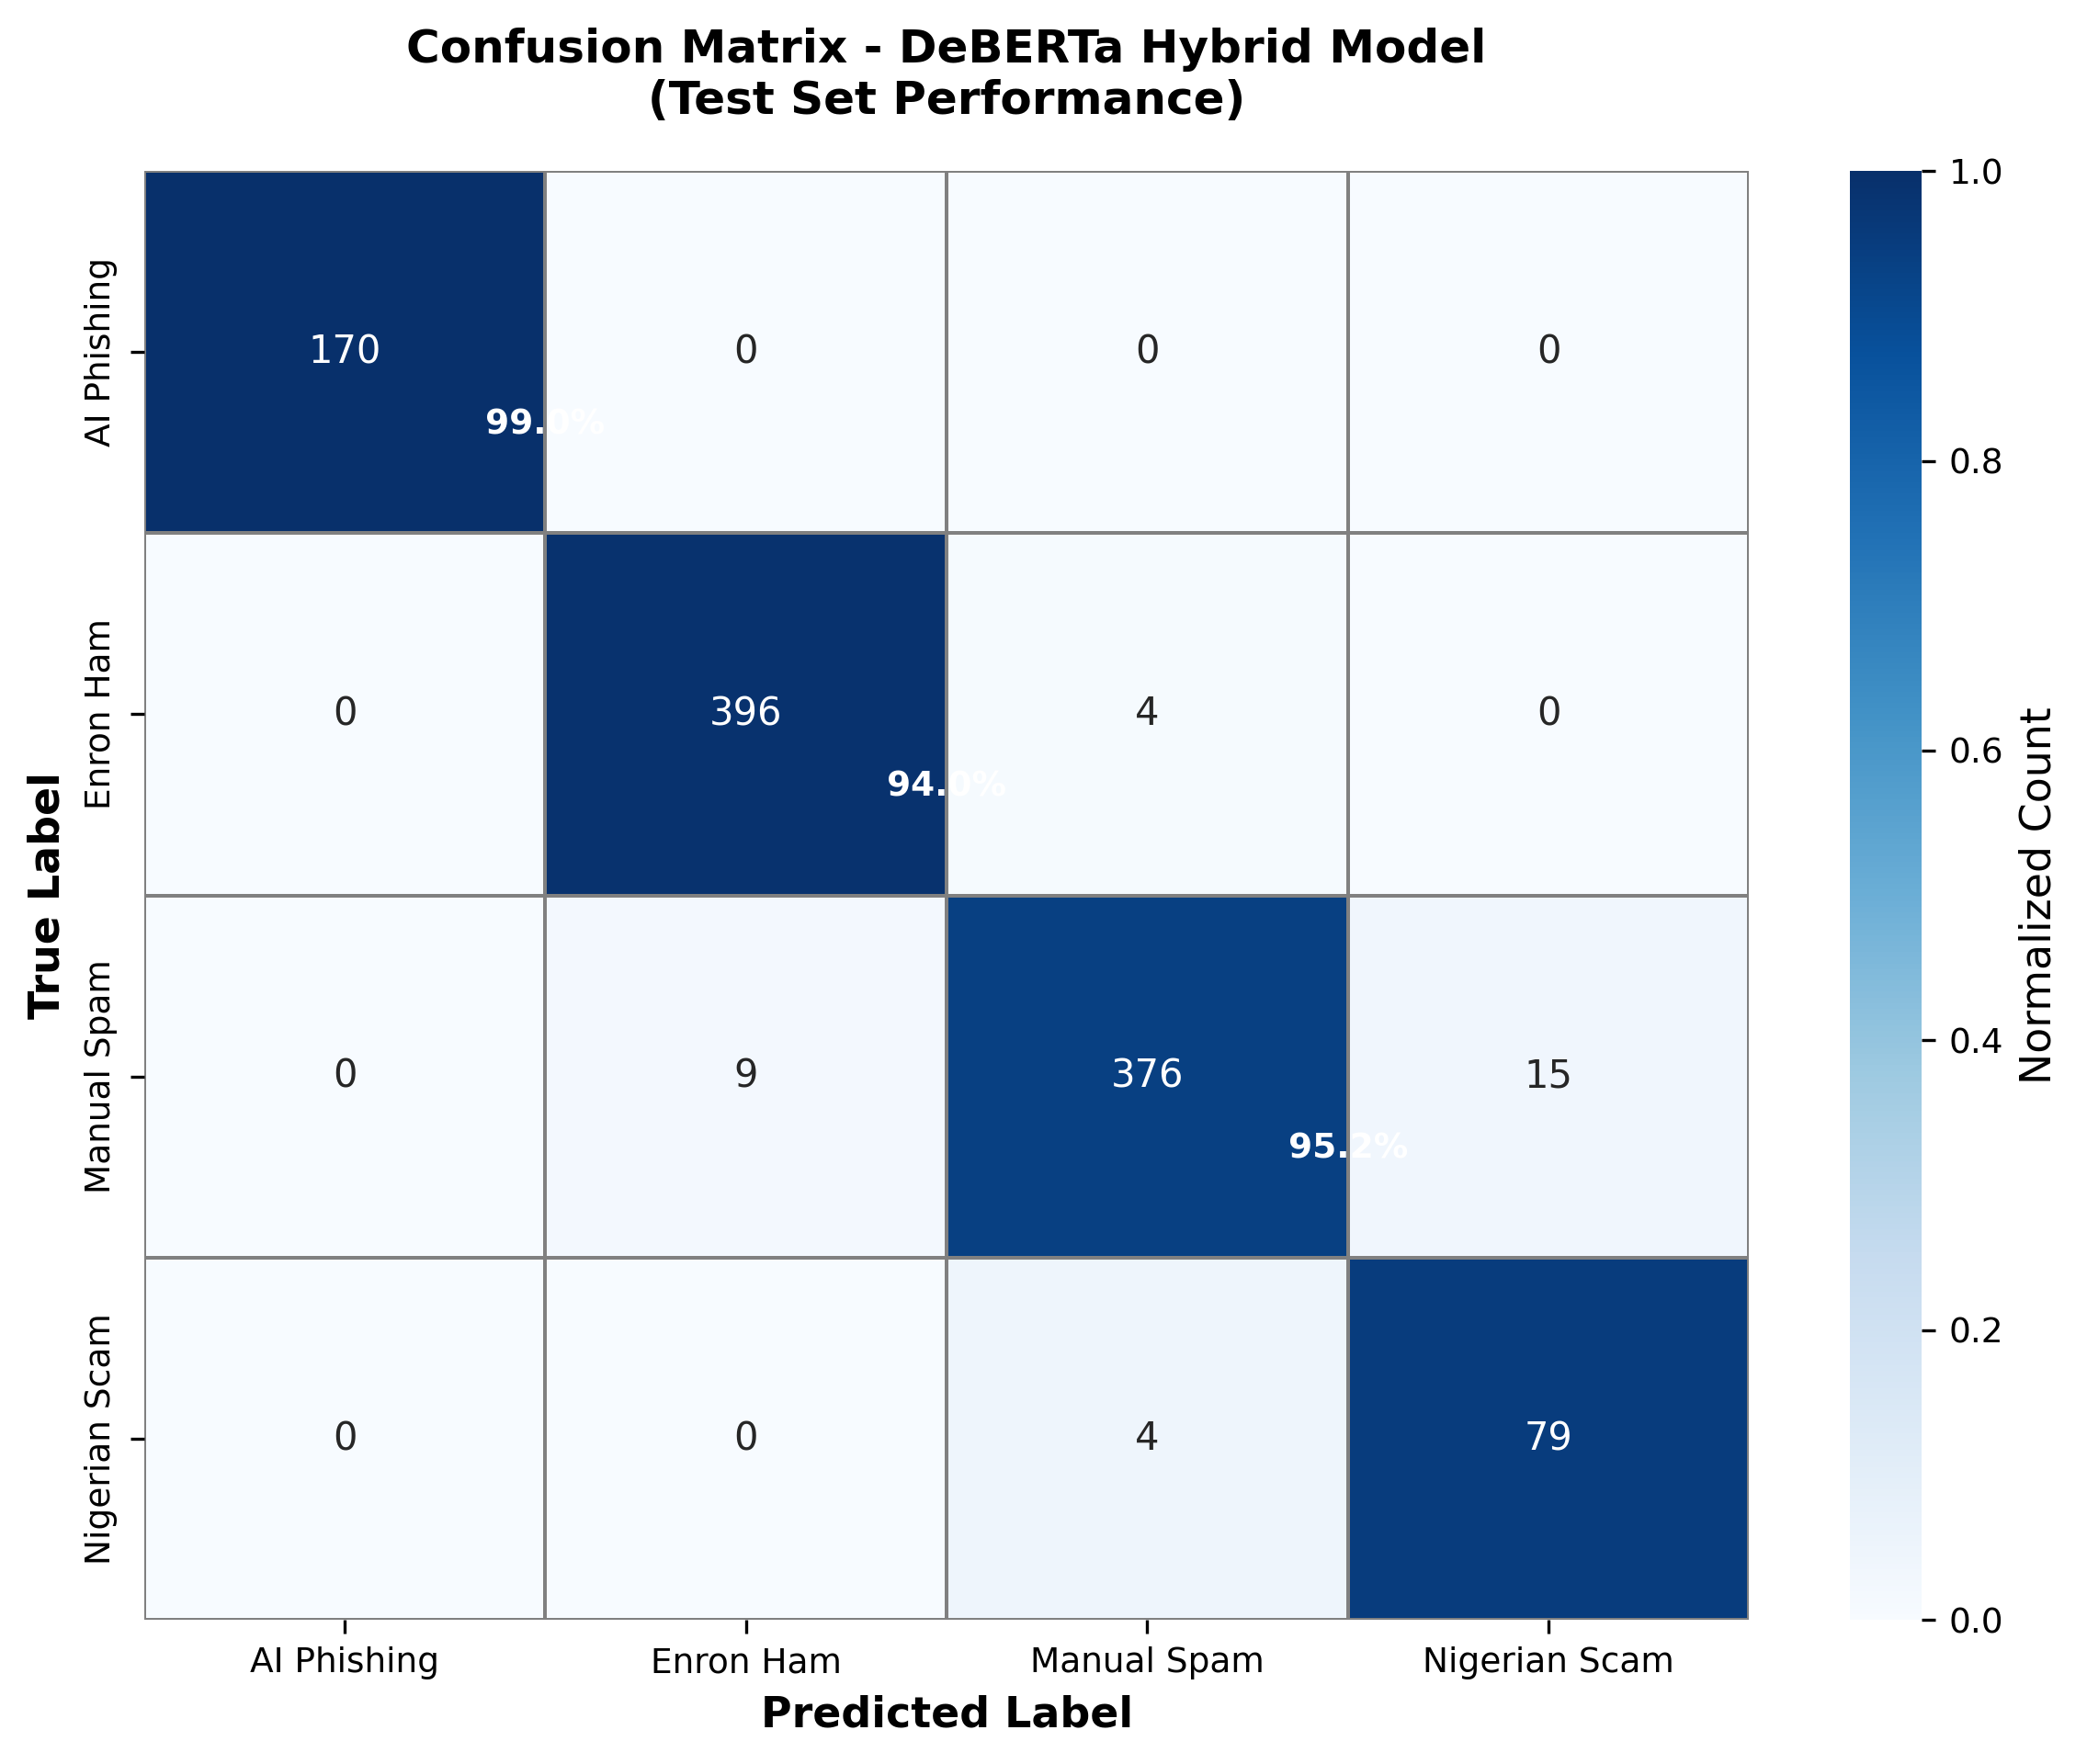

✓ Saved Figure 1: Confusion Matrix


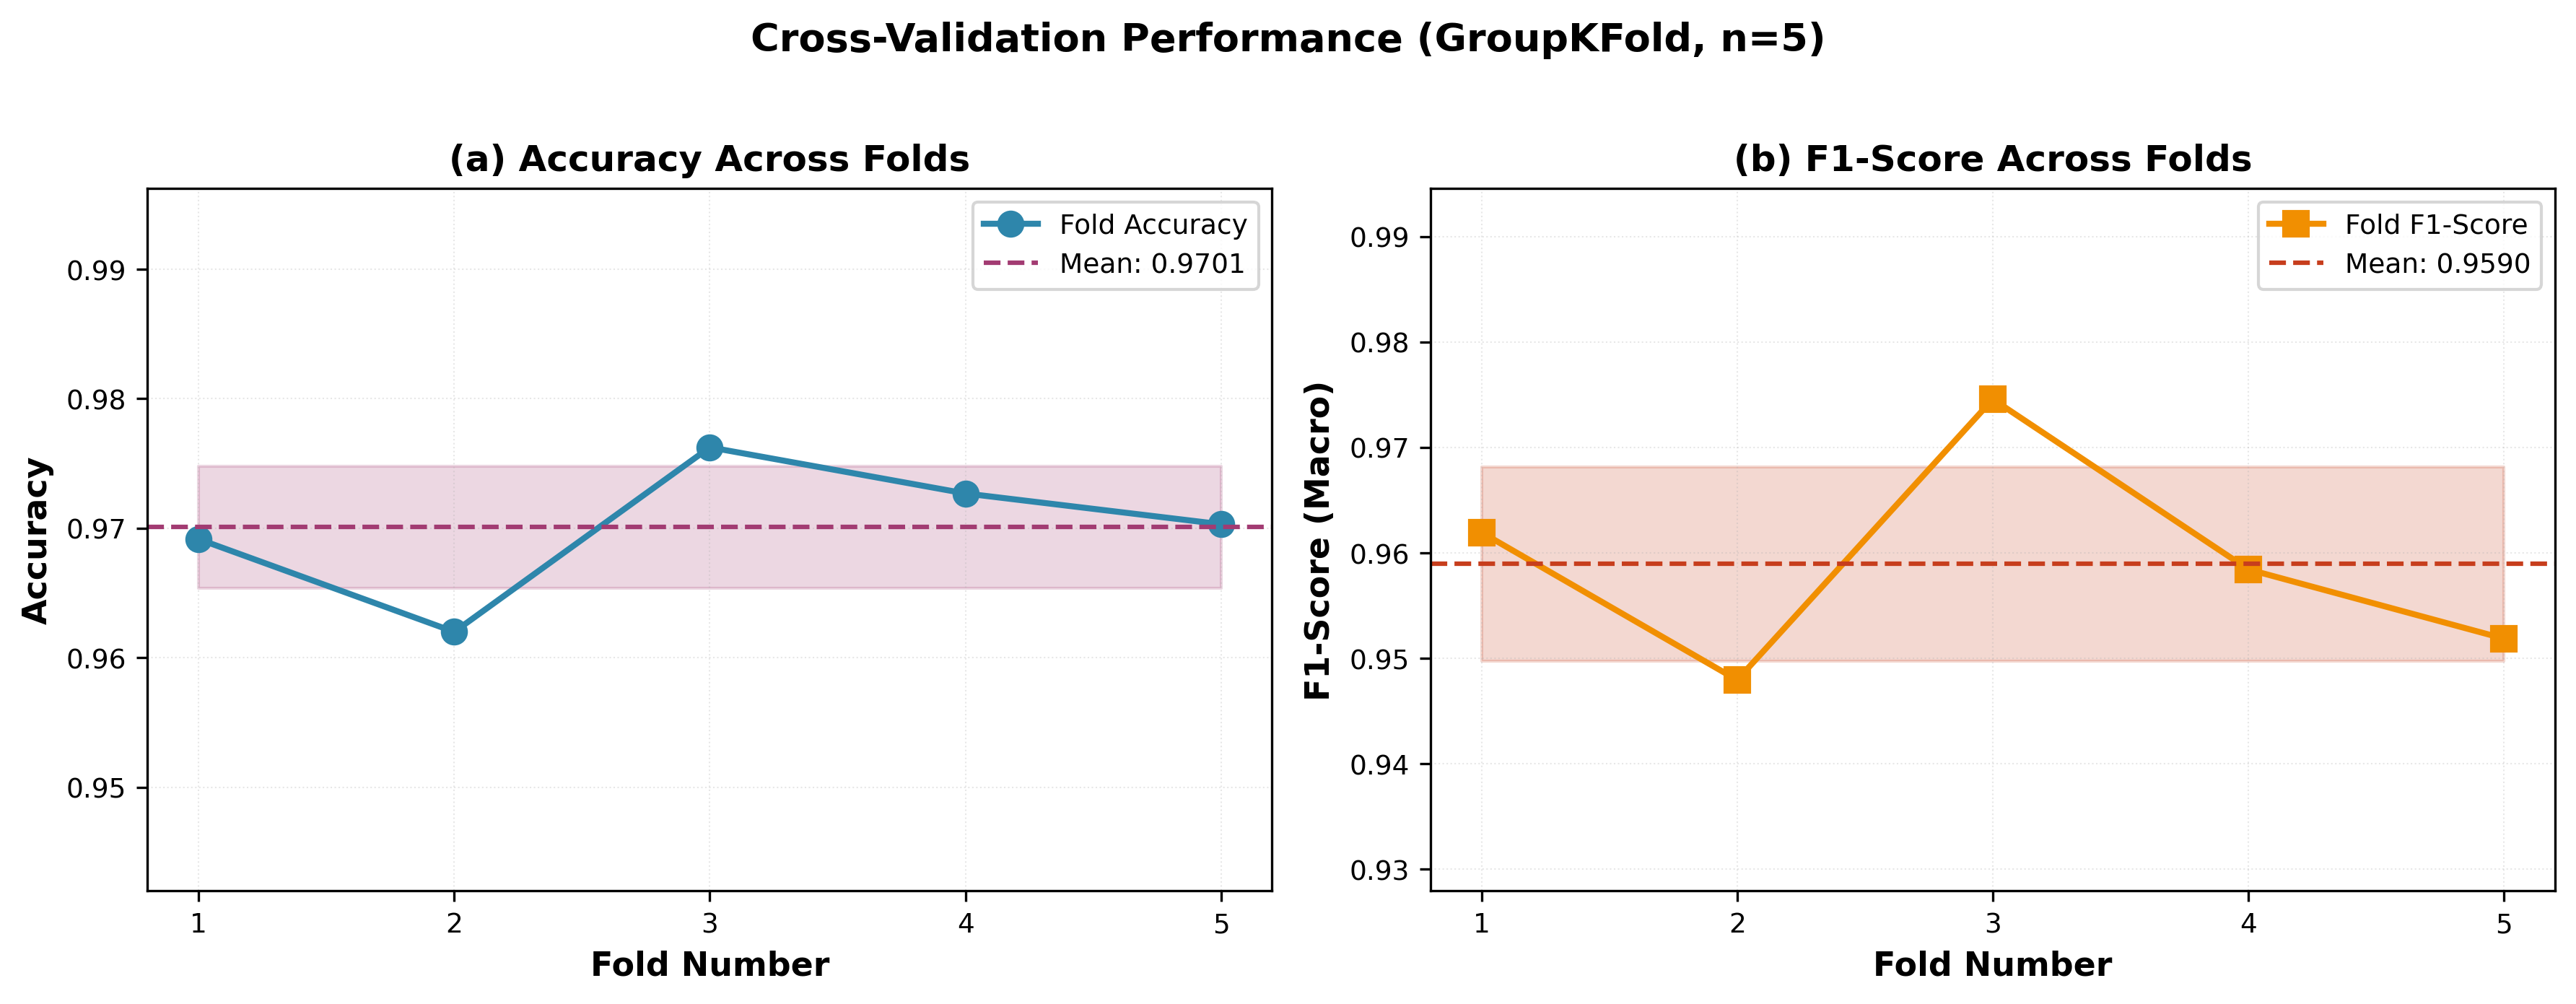

✓ Saved Figure 2: Cross-Validation Performance


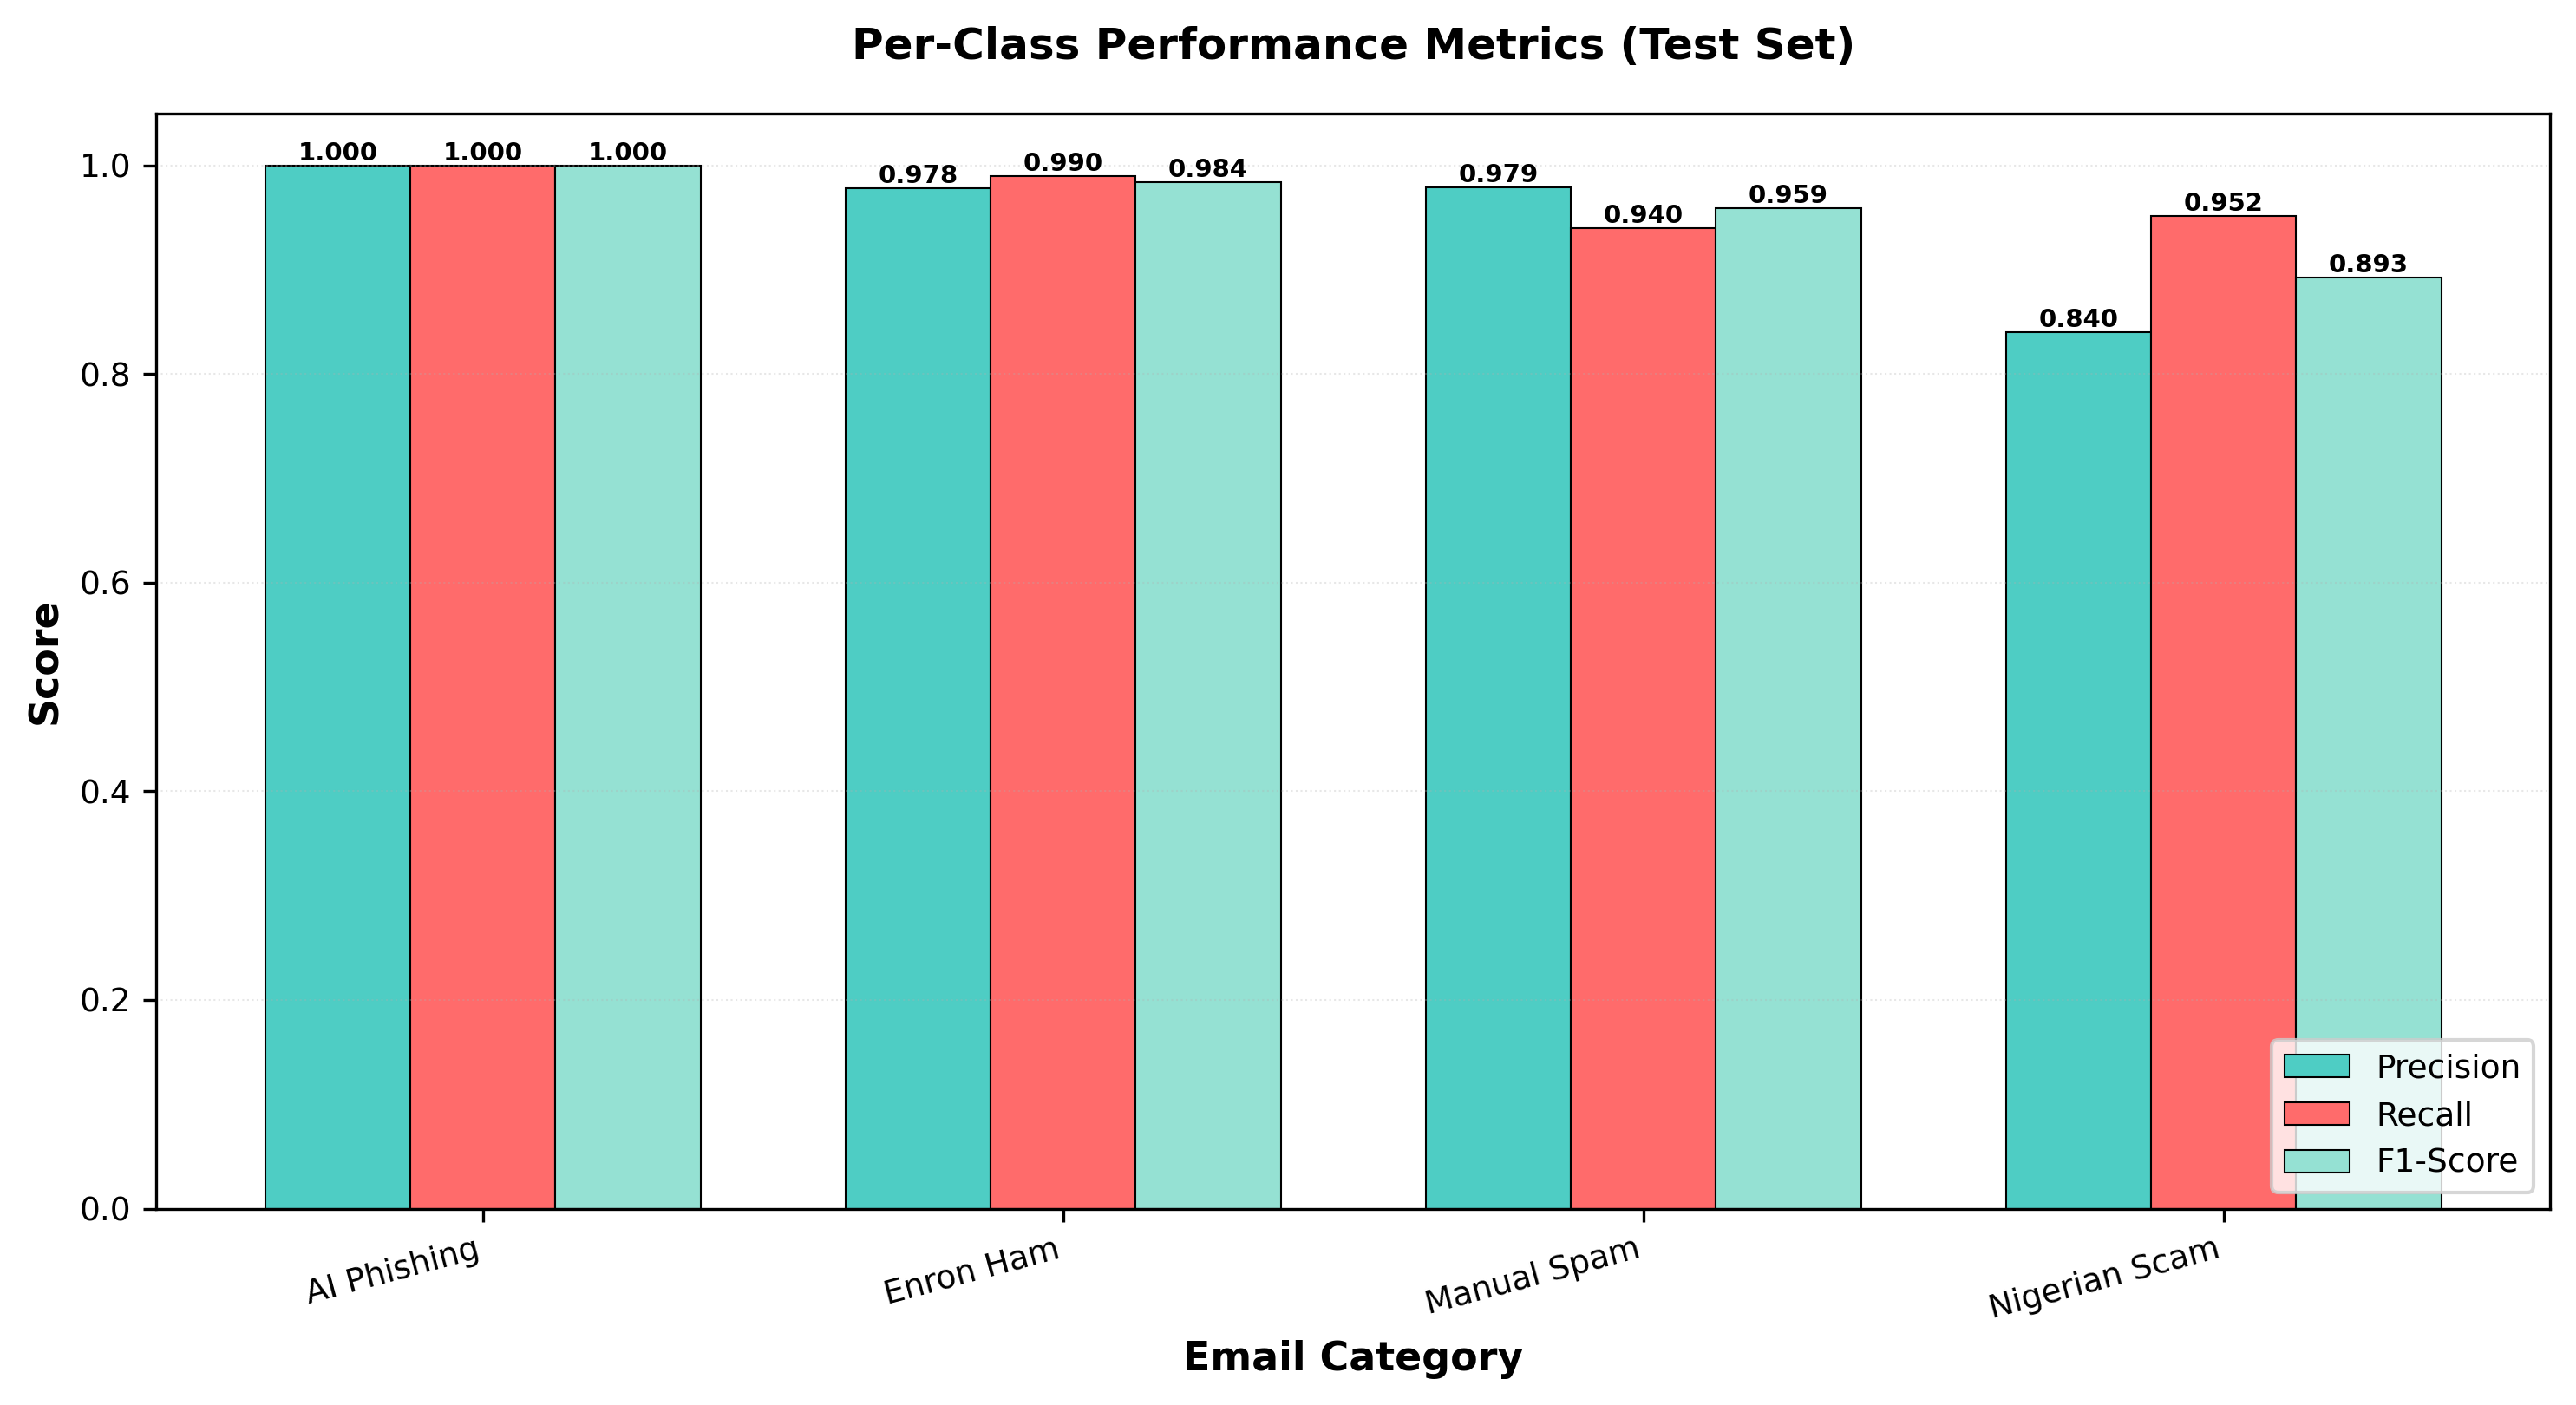

✓ Saved Figure 3: Per-Class Metrics


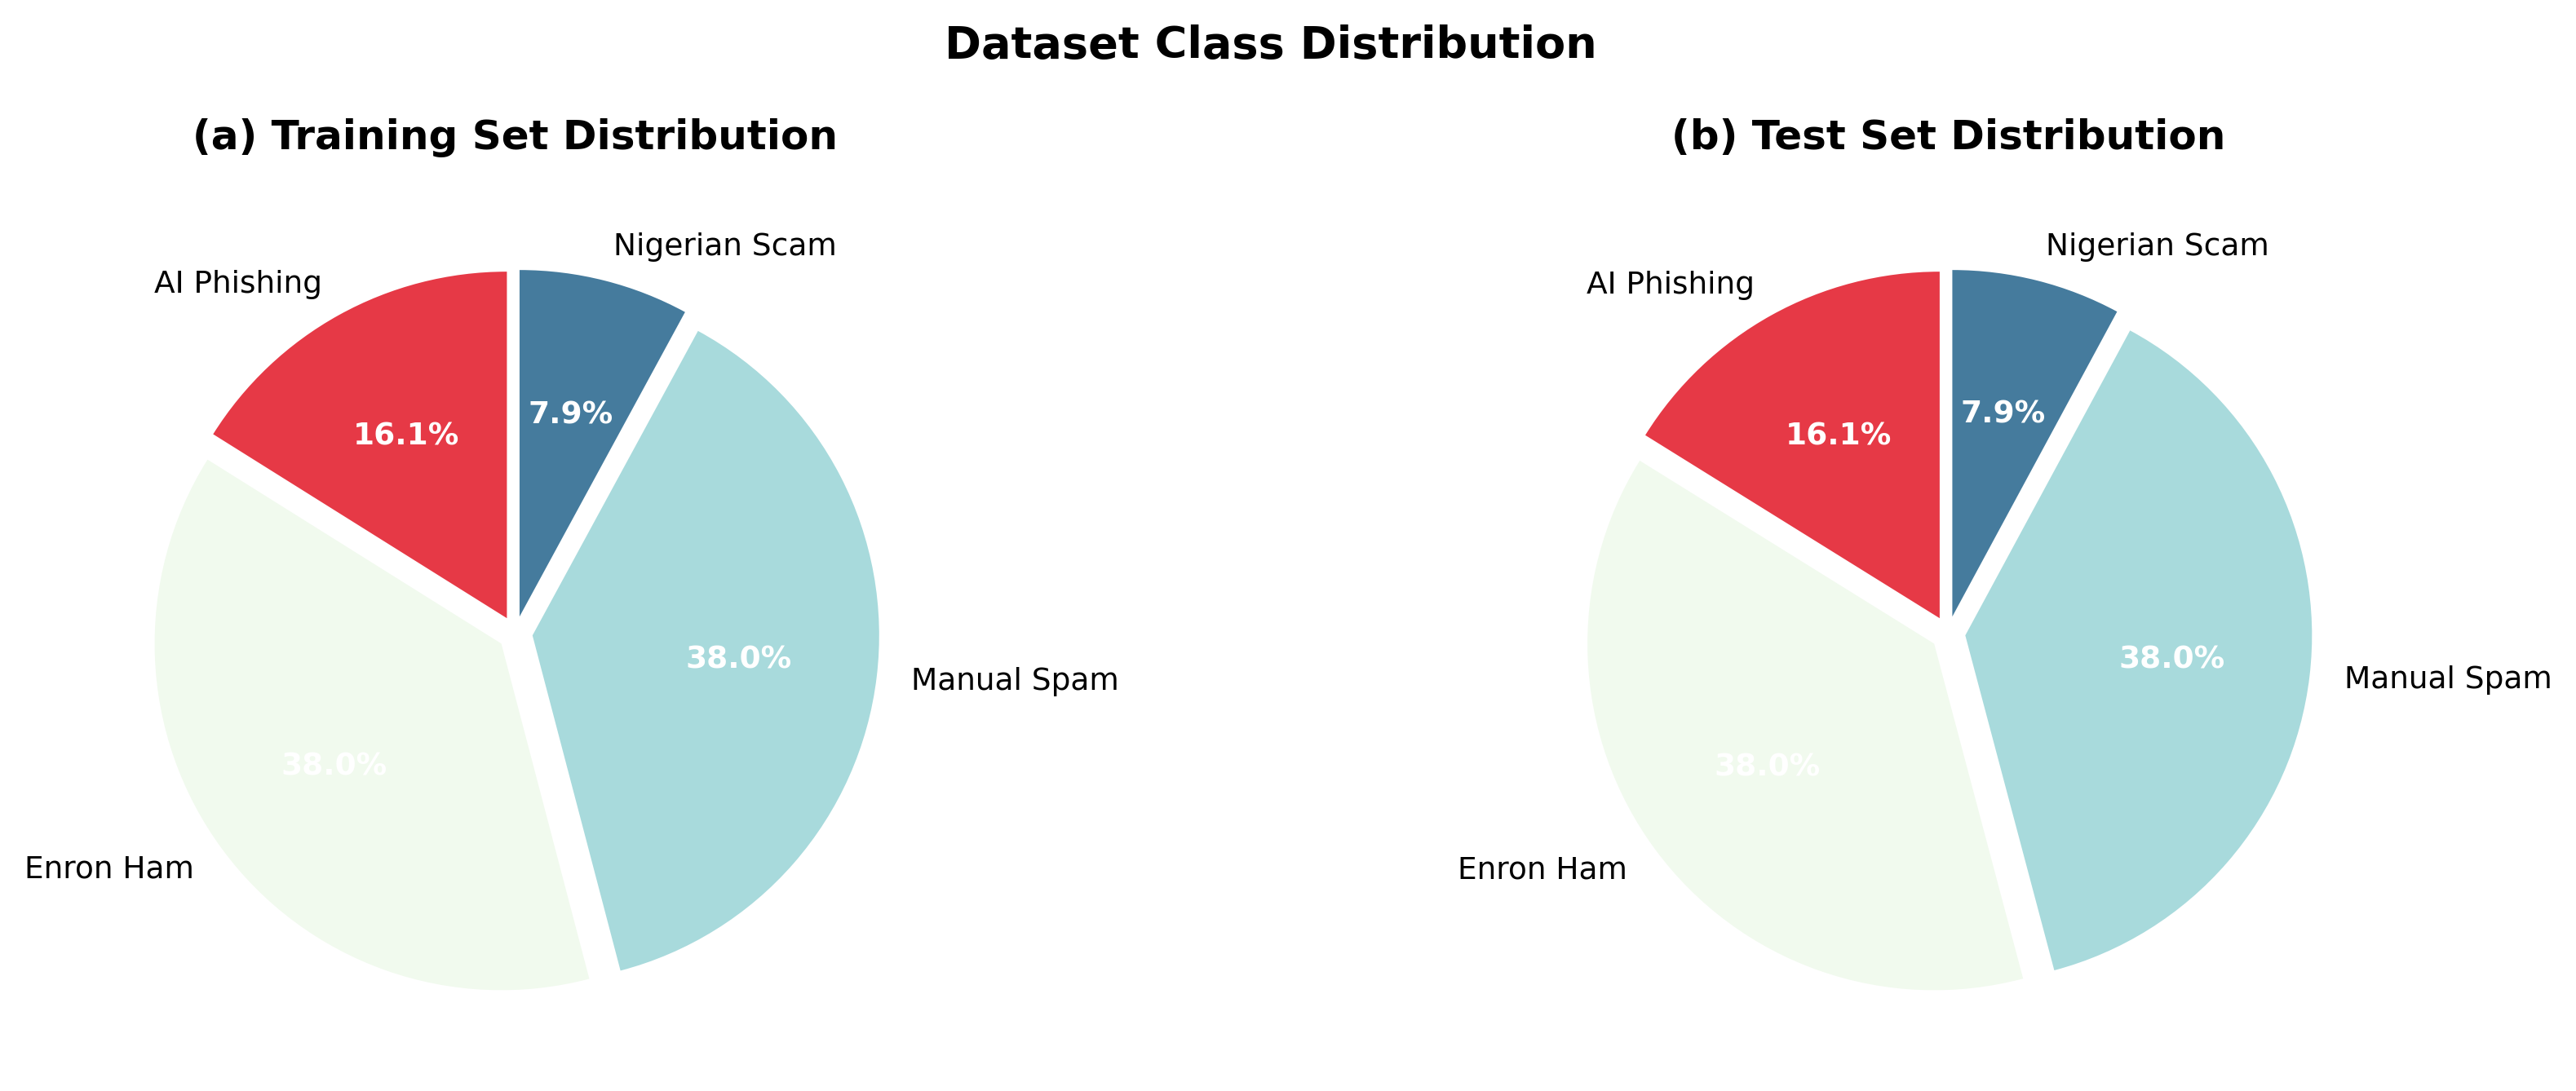

✓ Saved Figure 4: Class Distribution


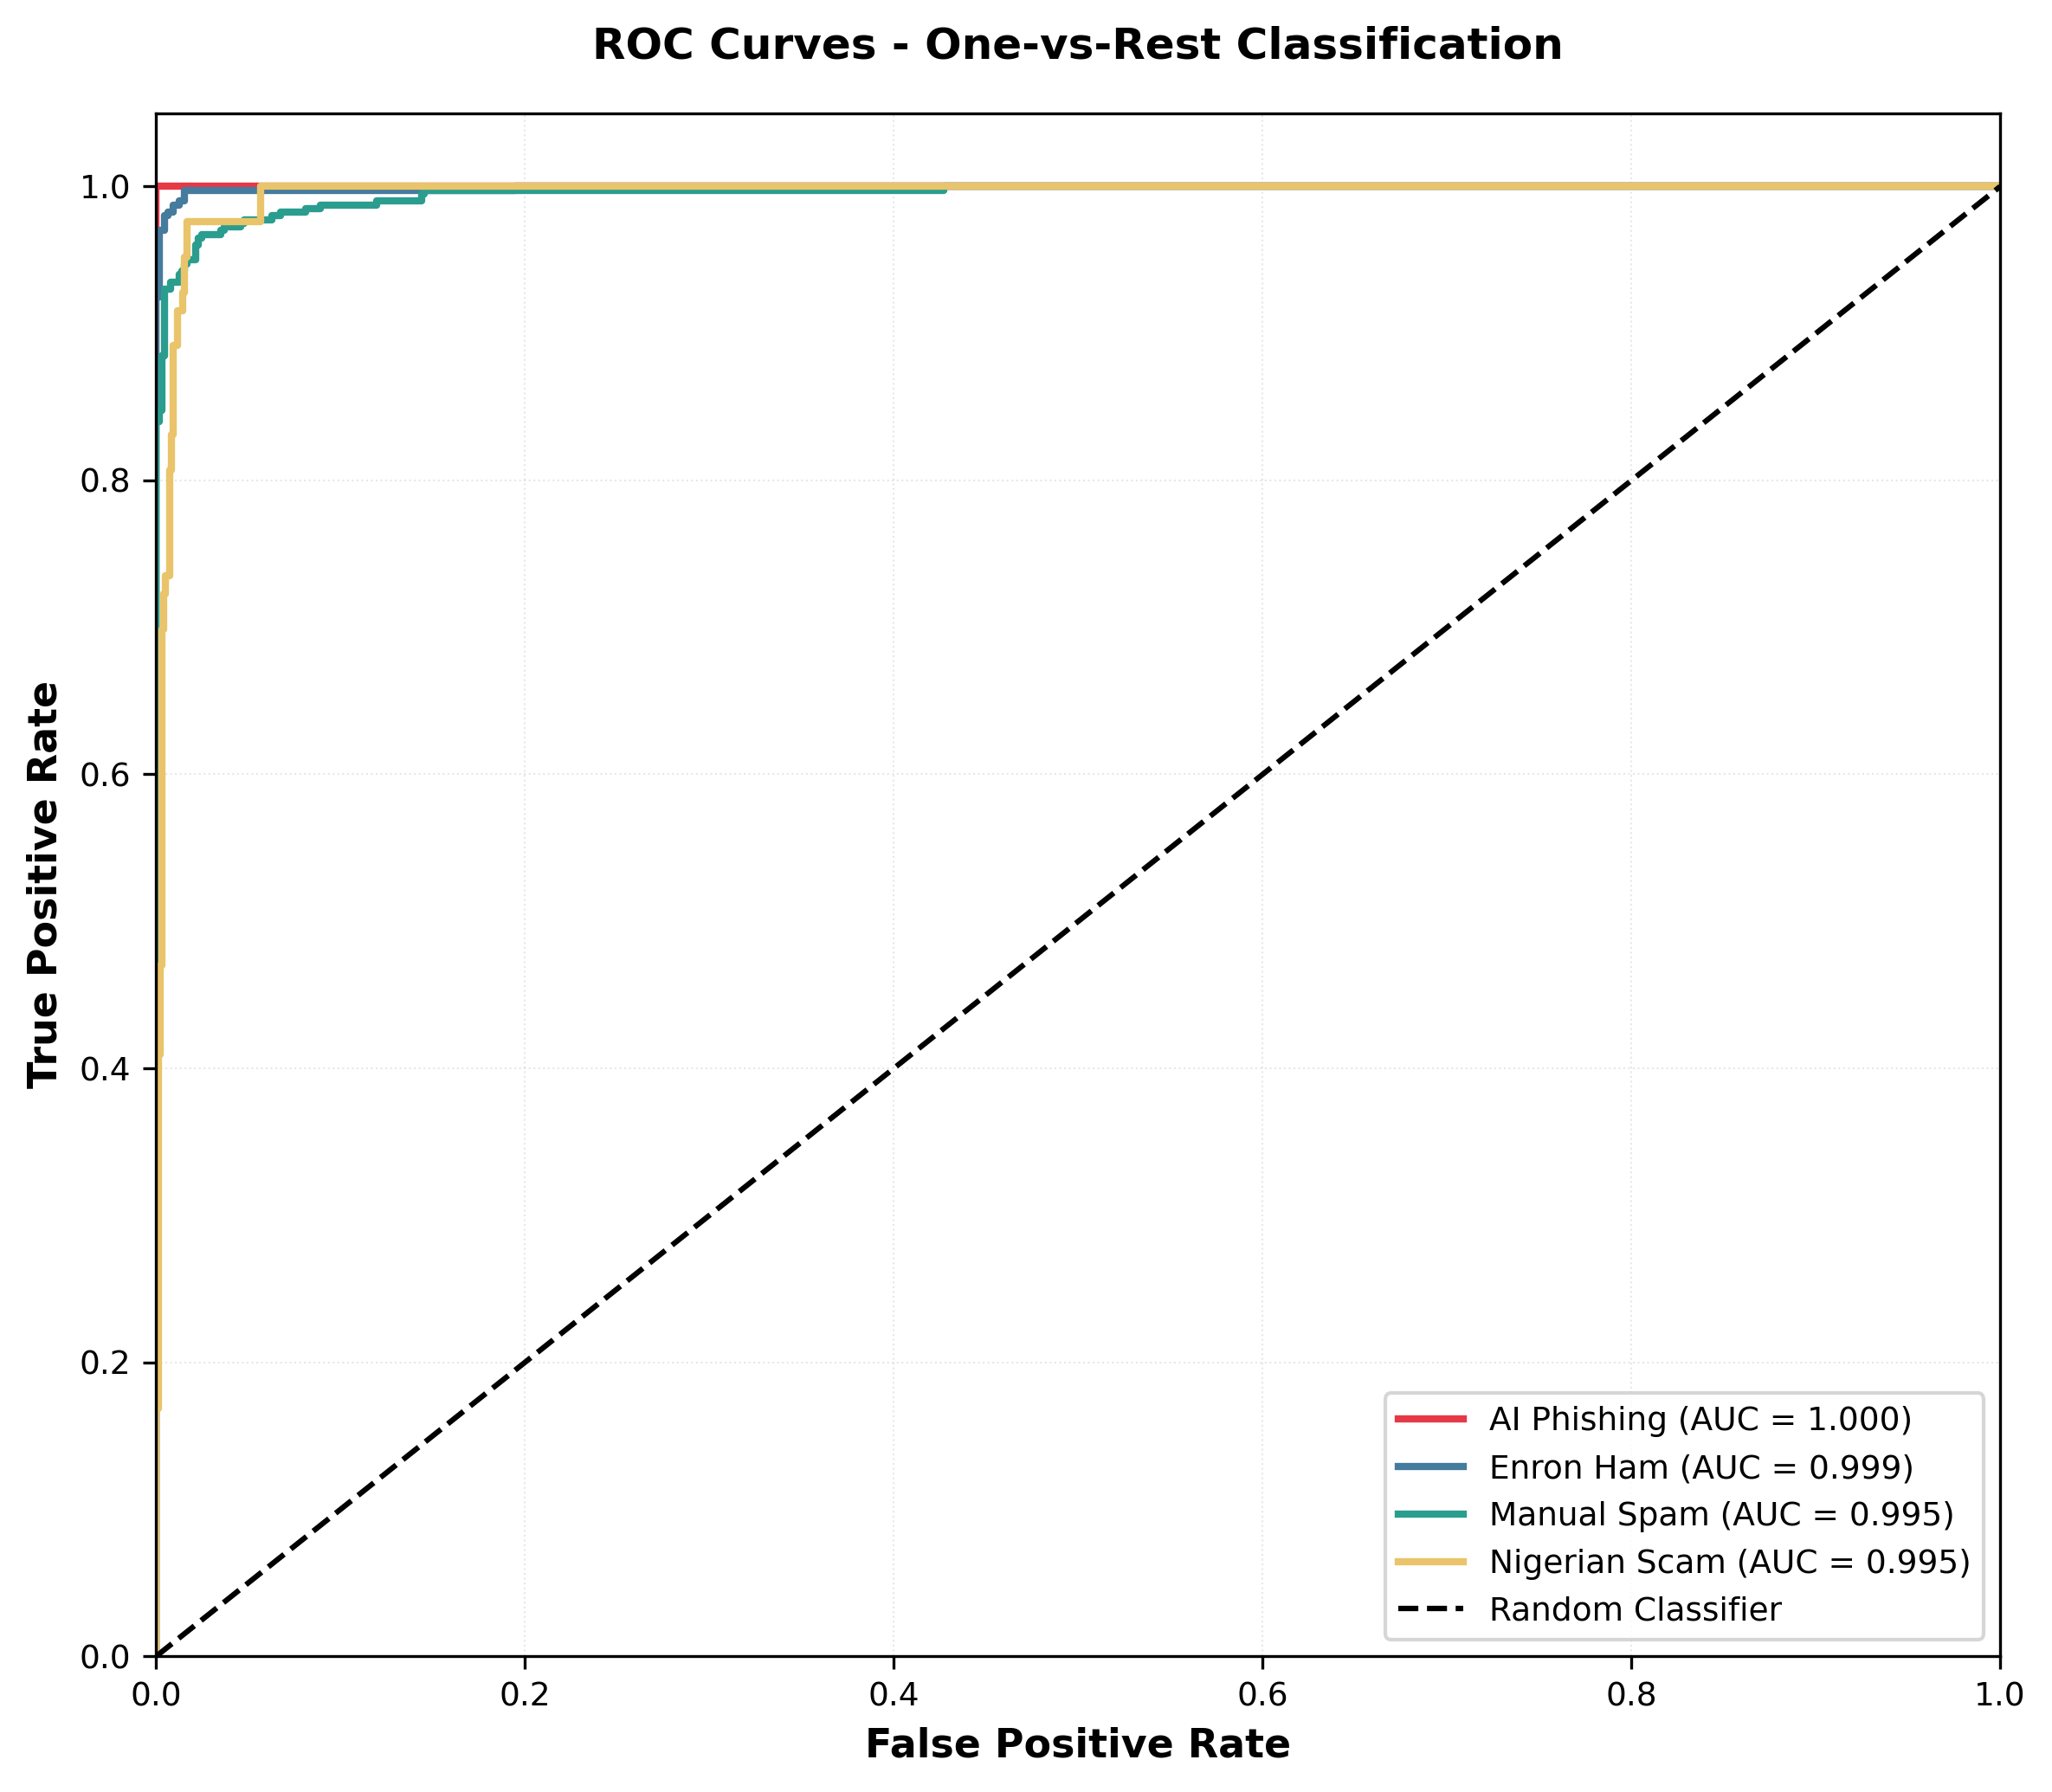

✓ Saved Figure 5: ROC Curves


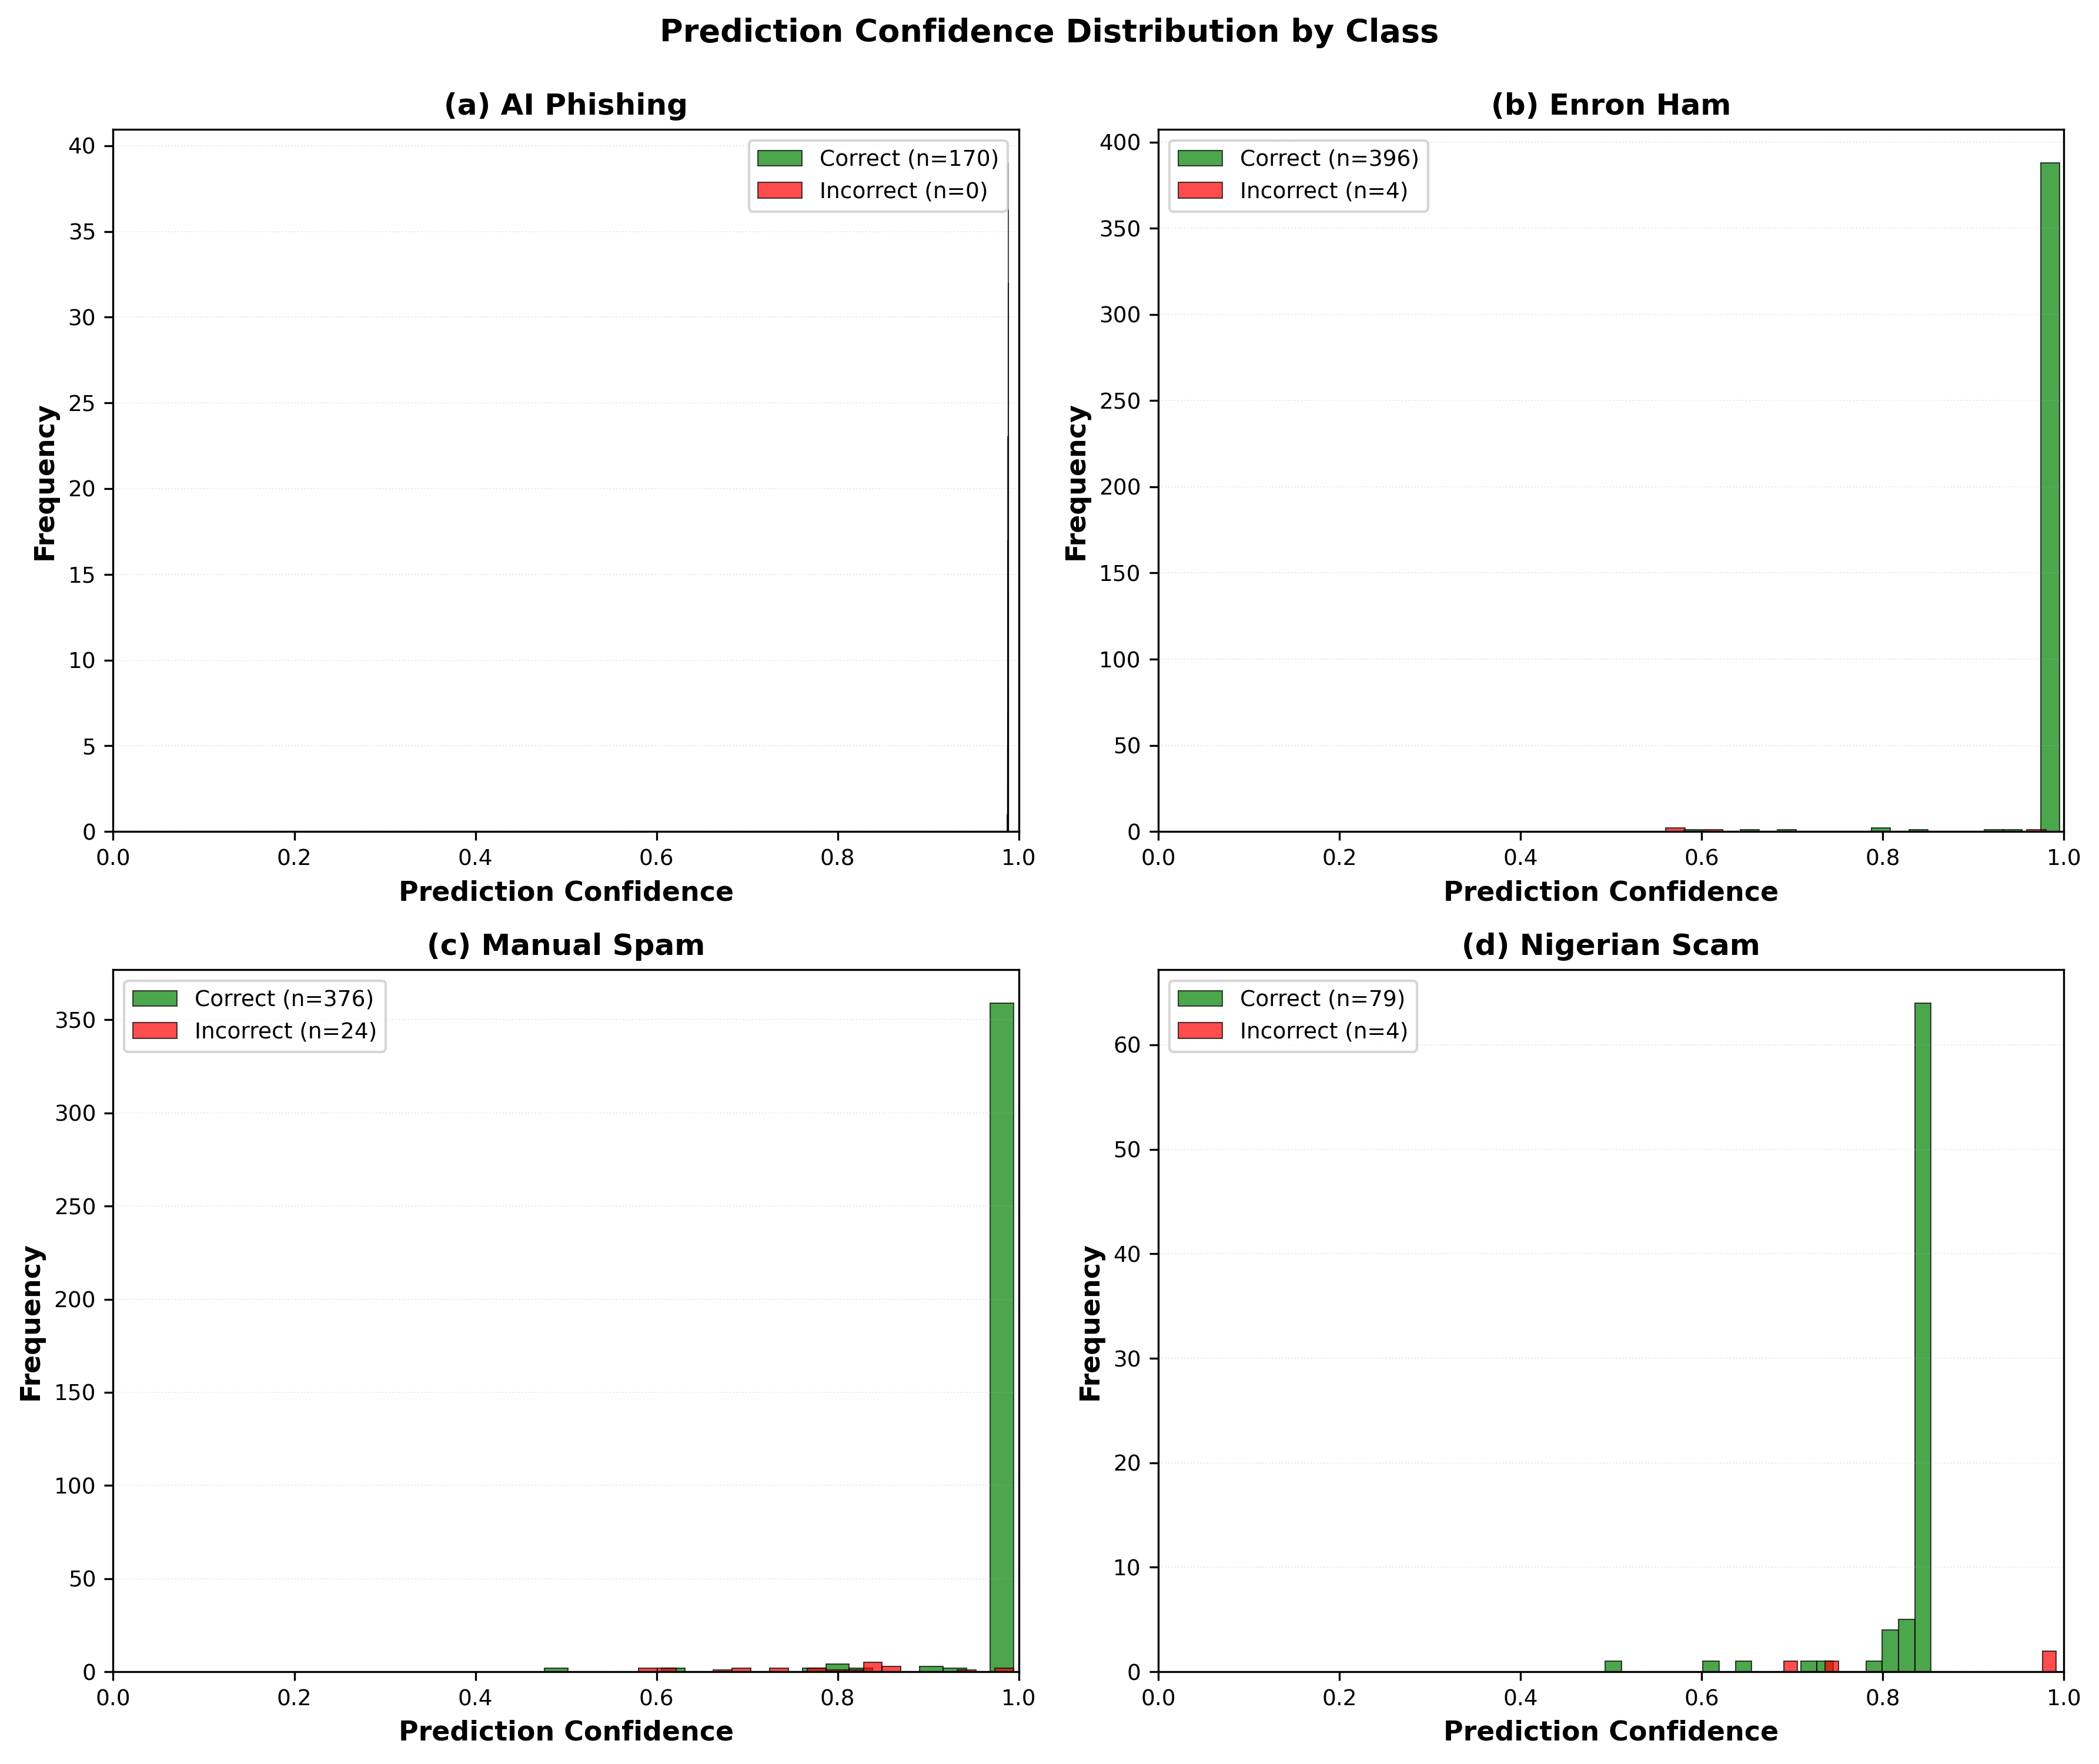

✓ Saved Figure 6: Confidence Distribution


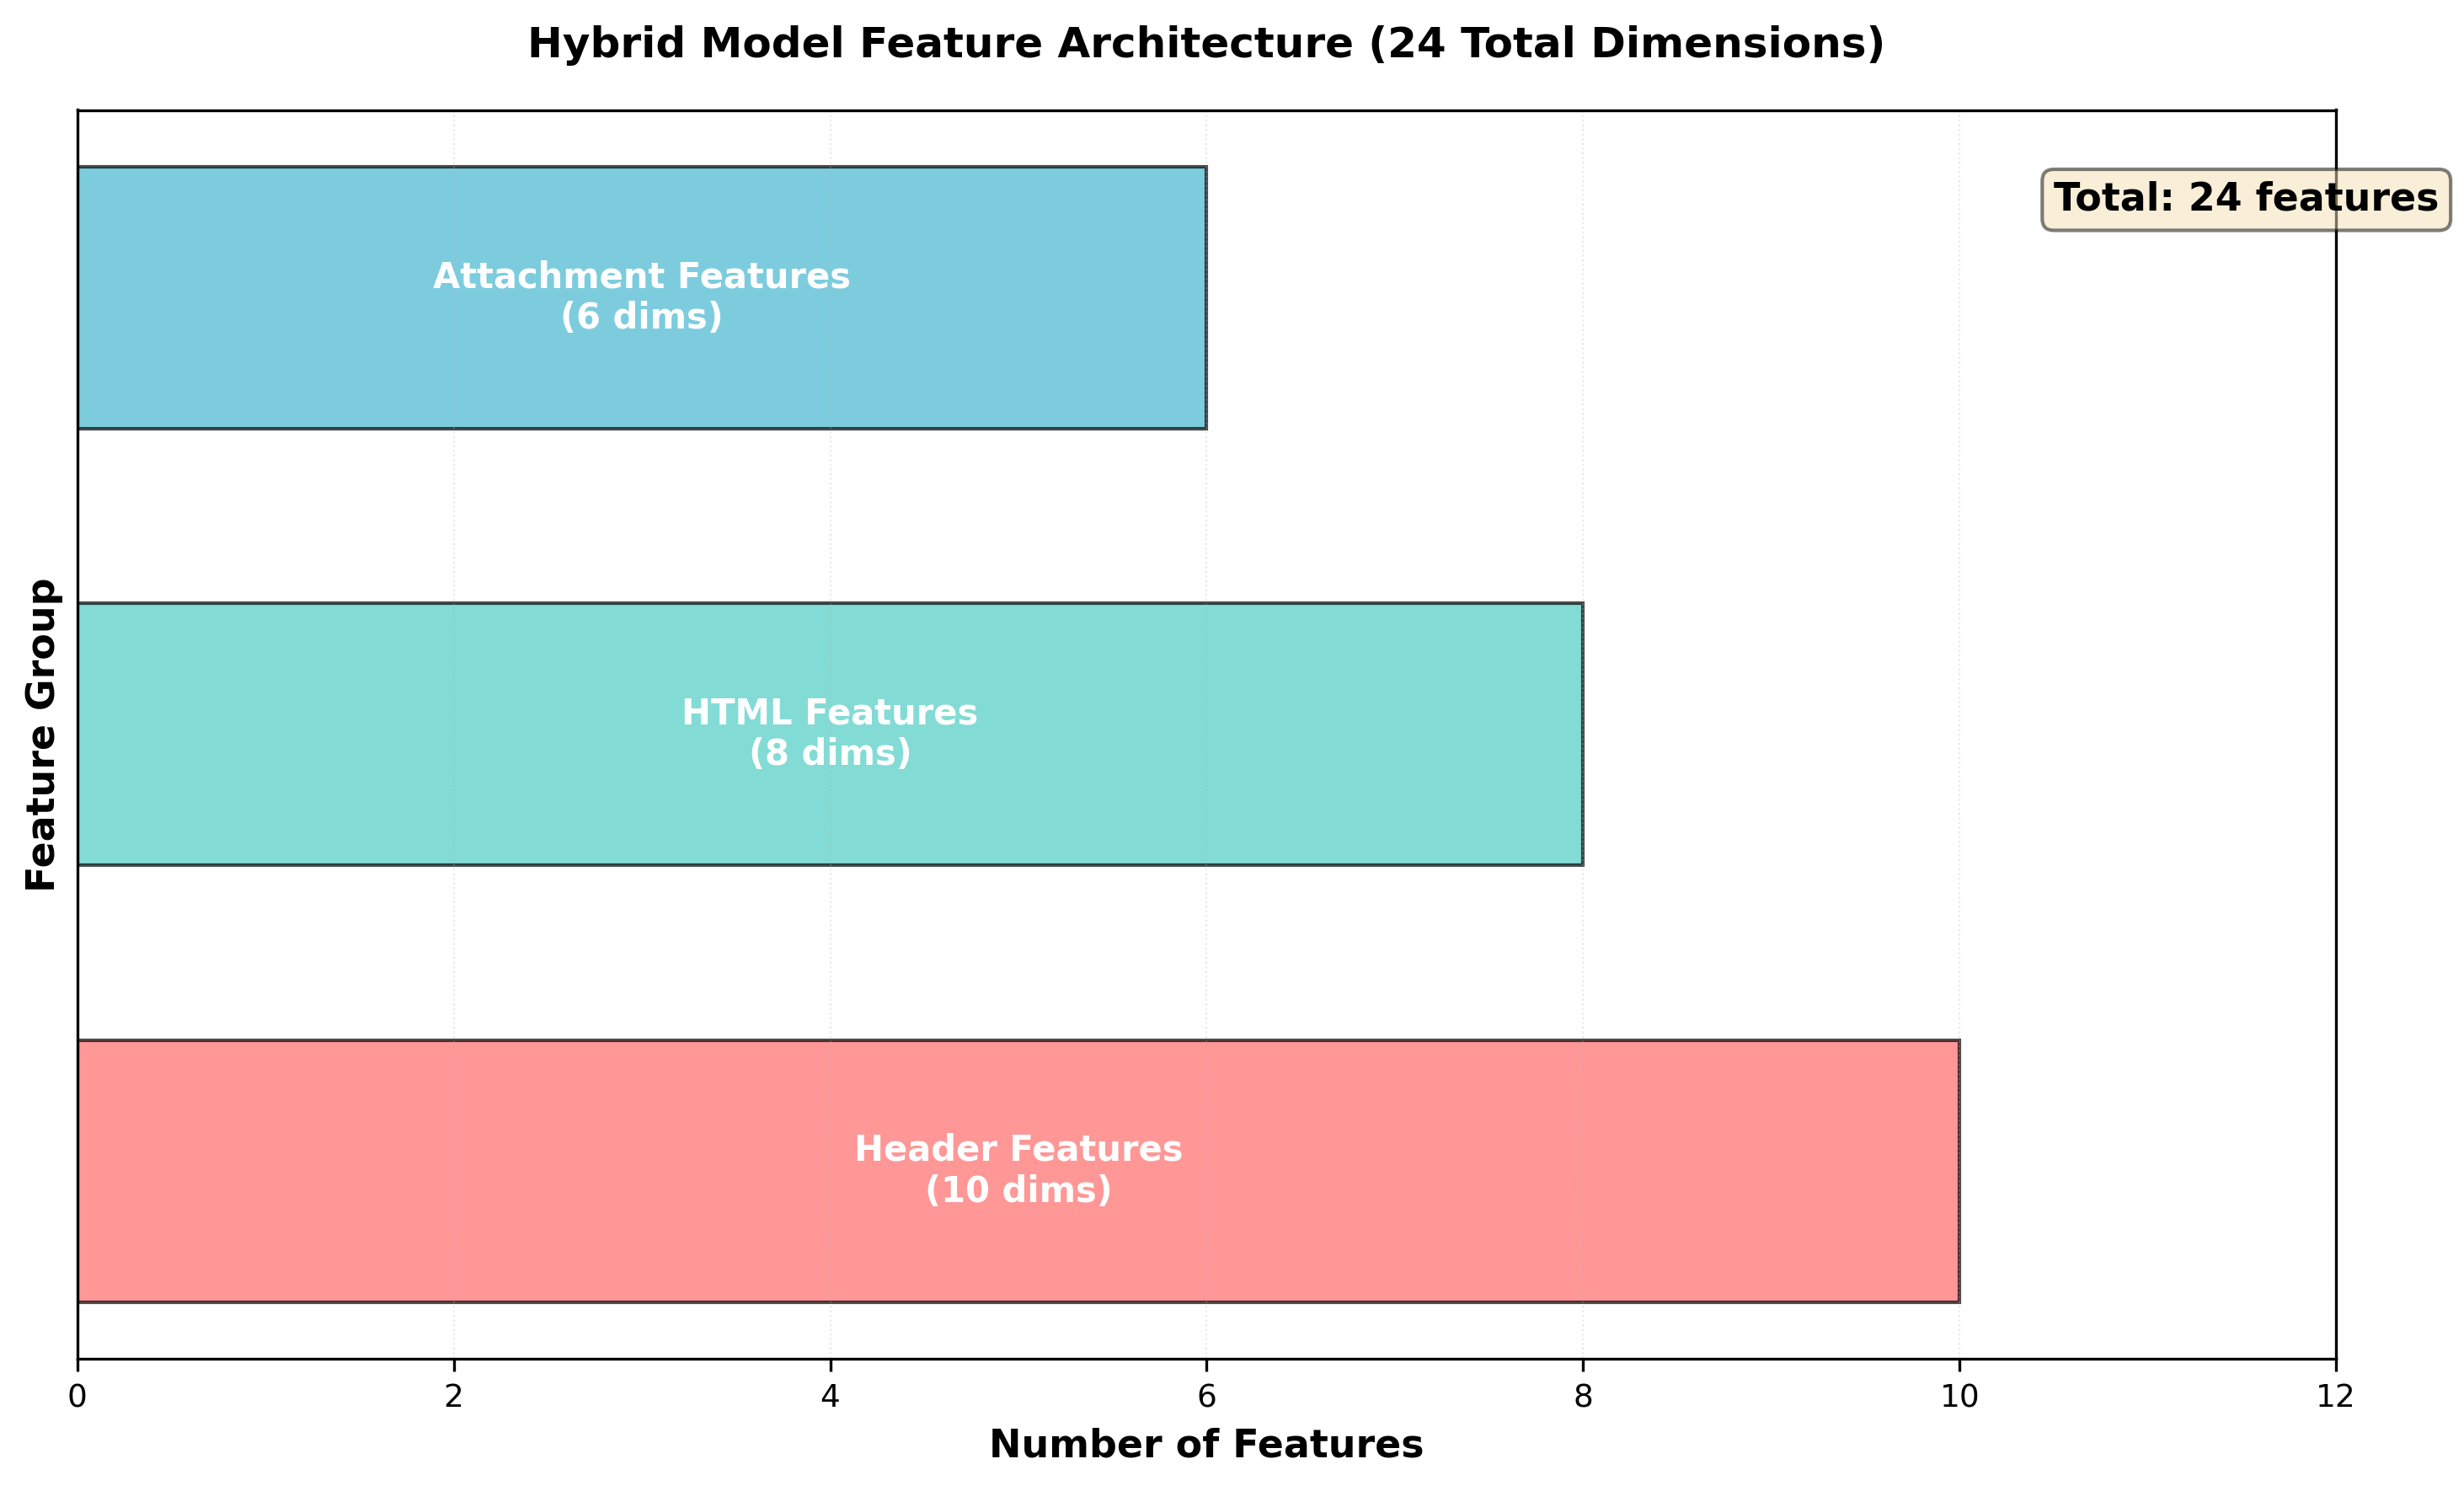

✓ Saved Figure 7: Feature Architecture


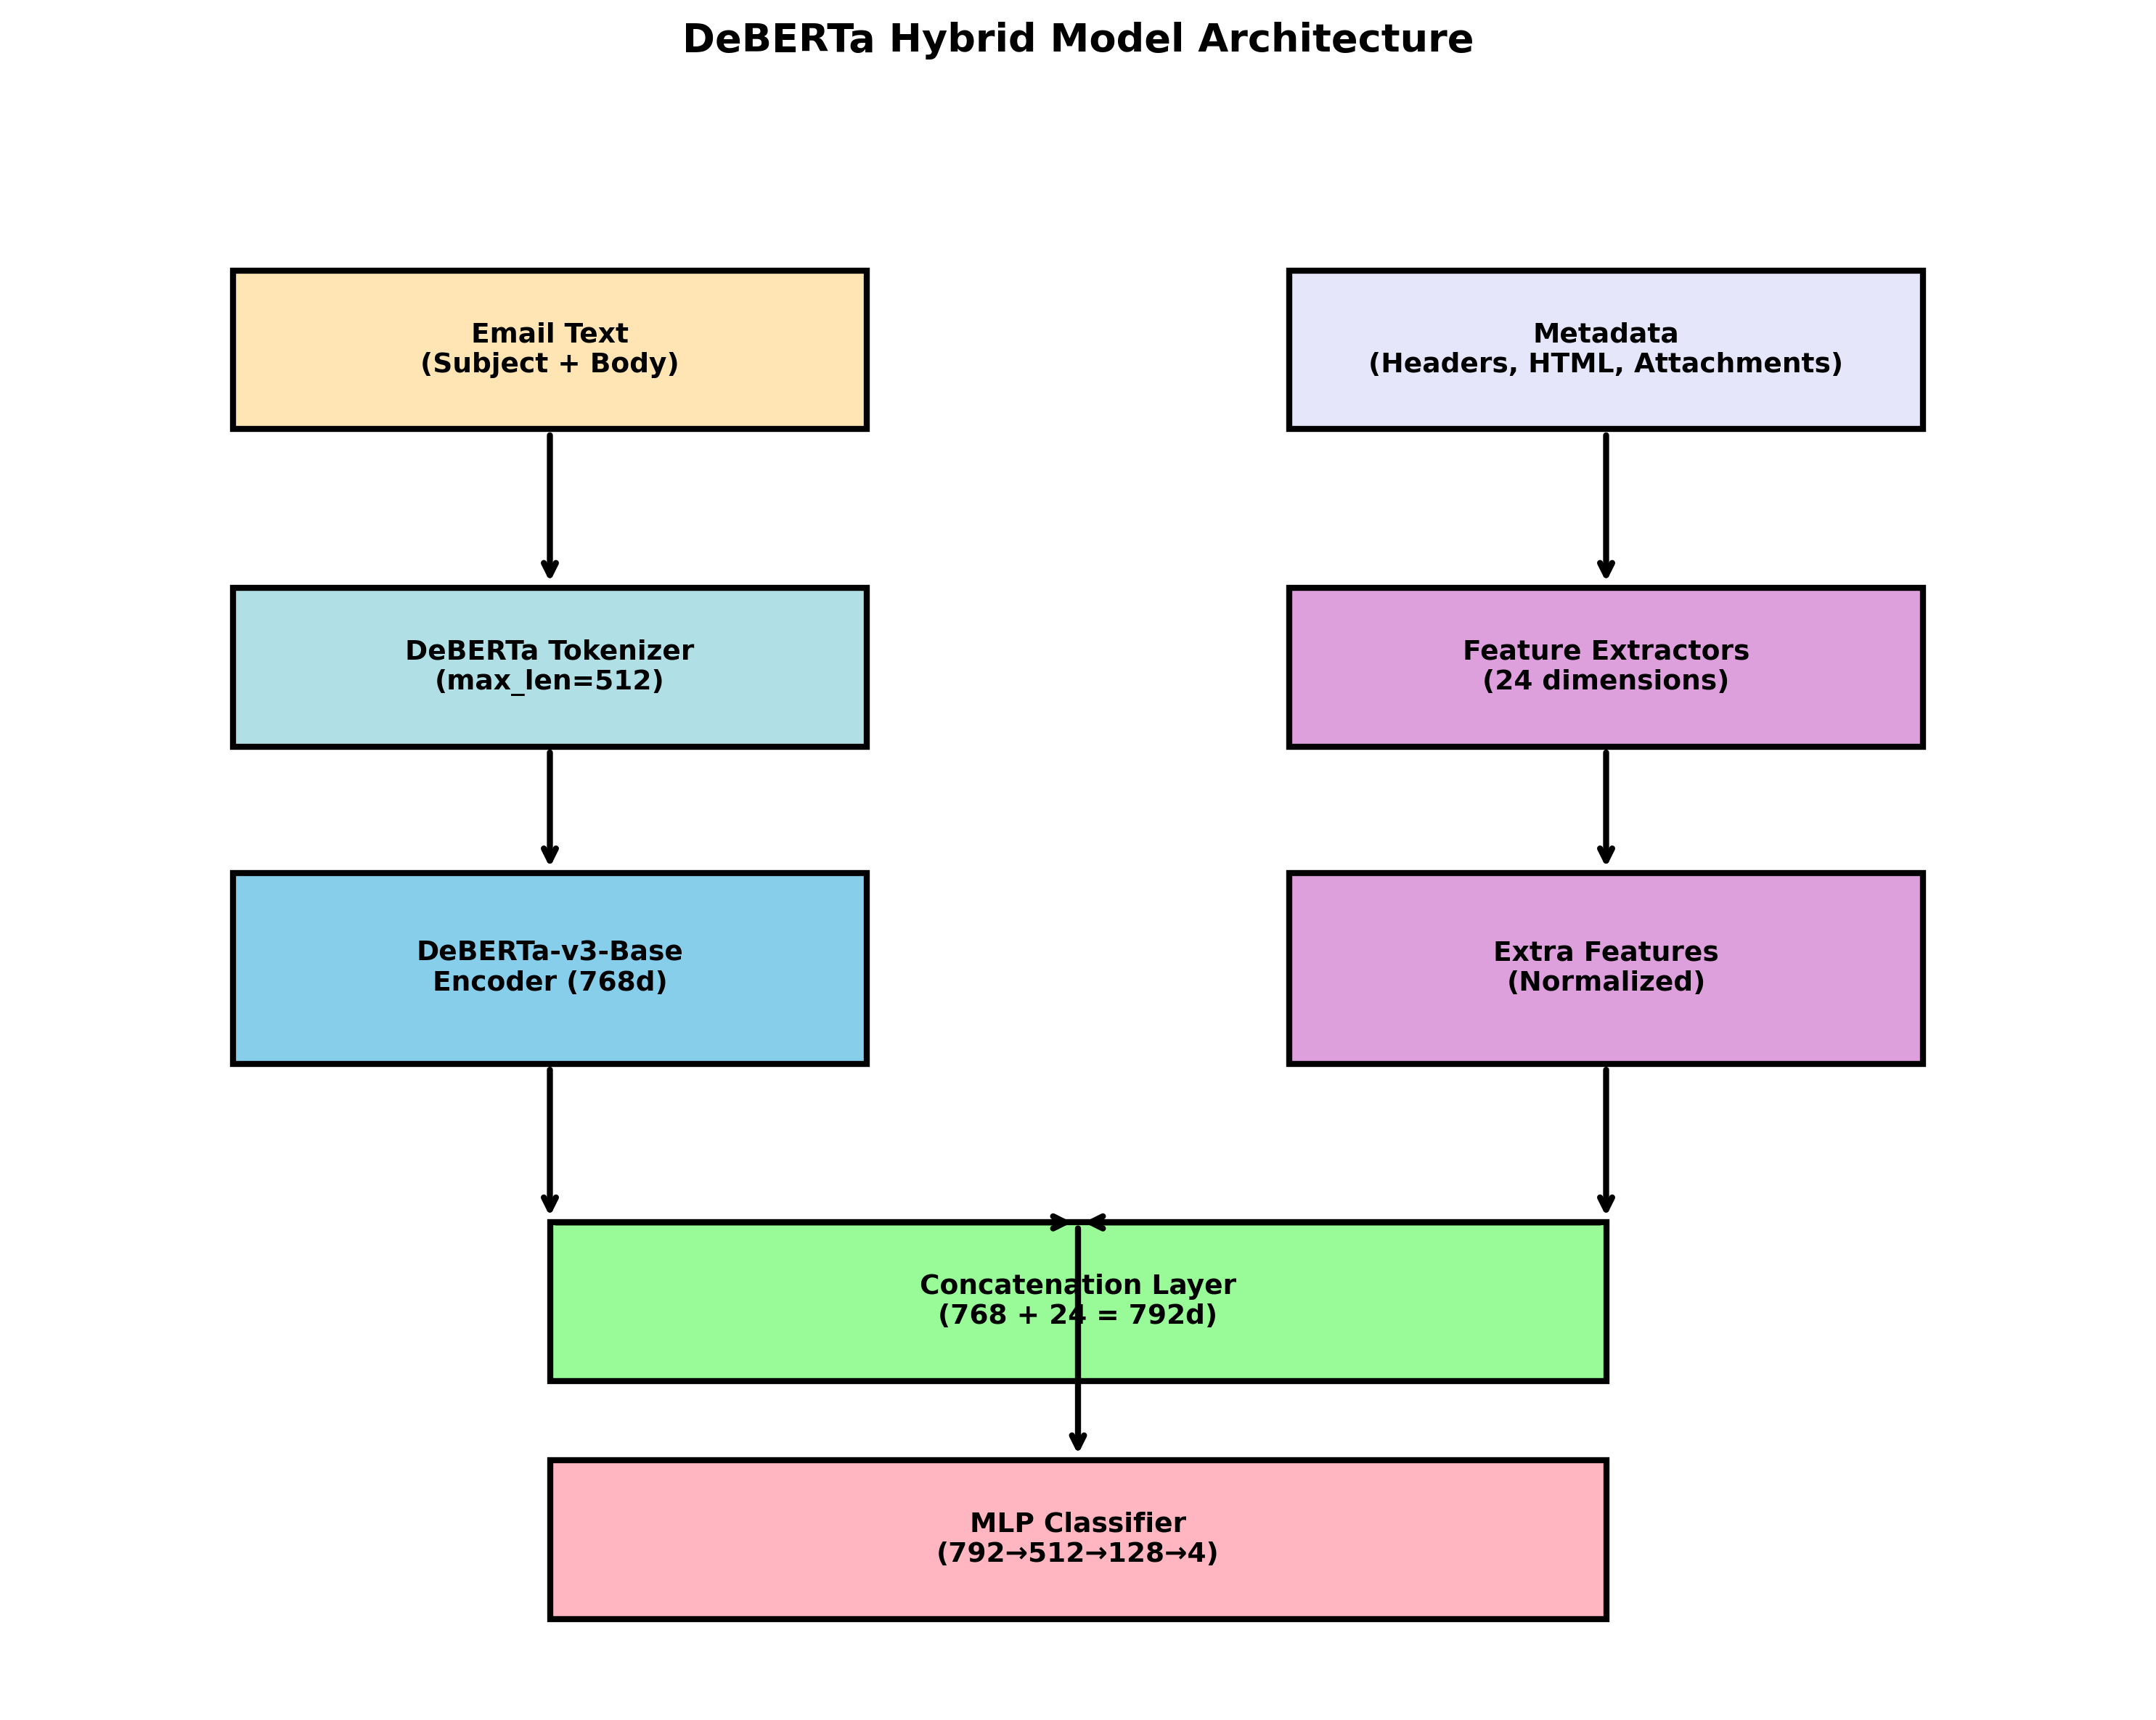

✓ Saved Figure 8: Model Architecture


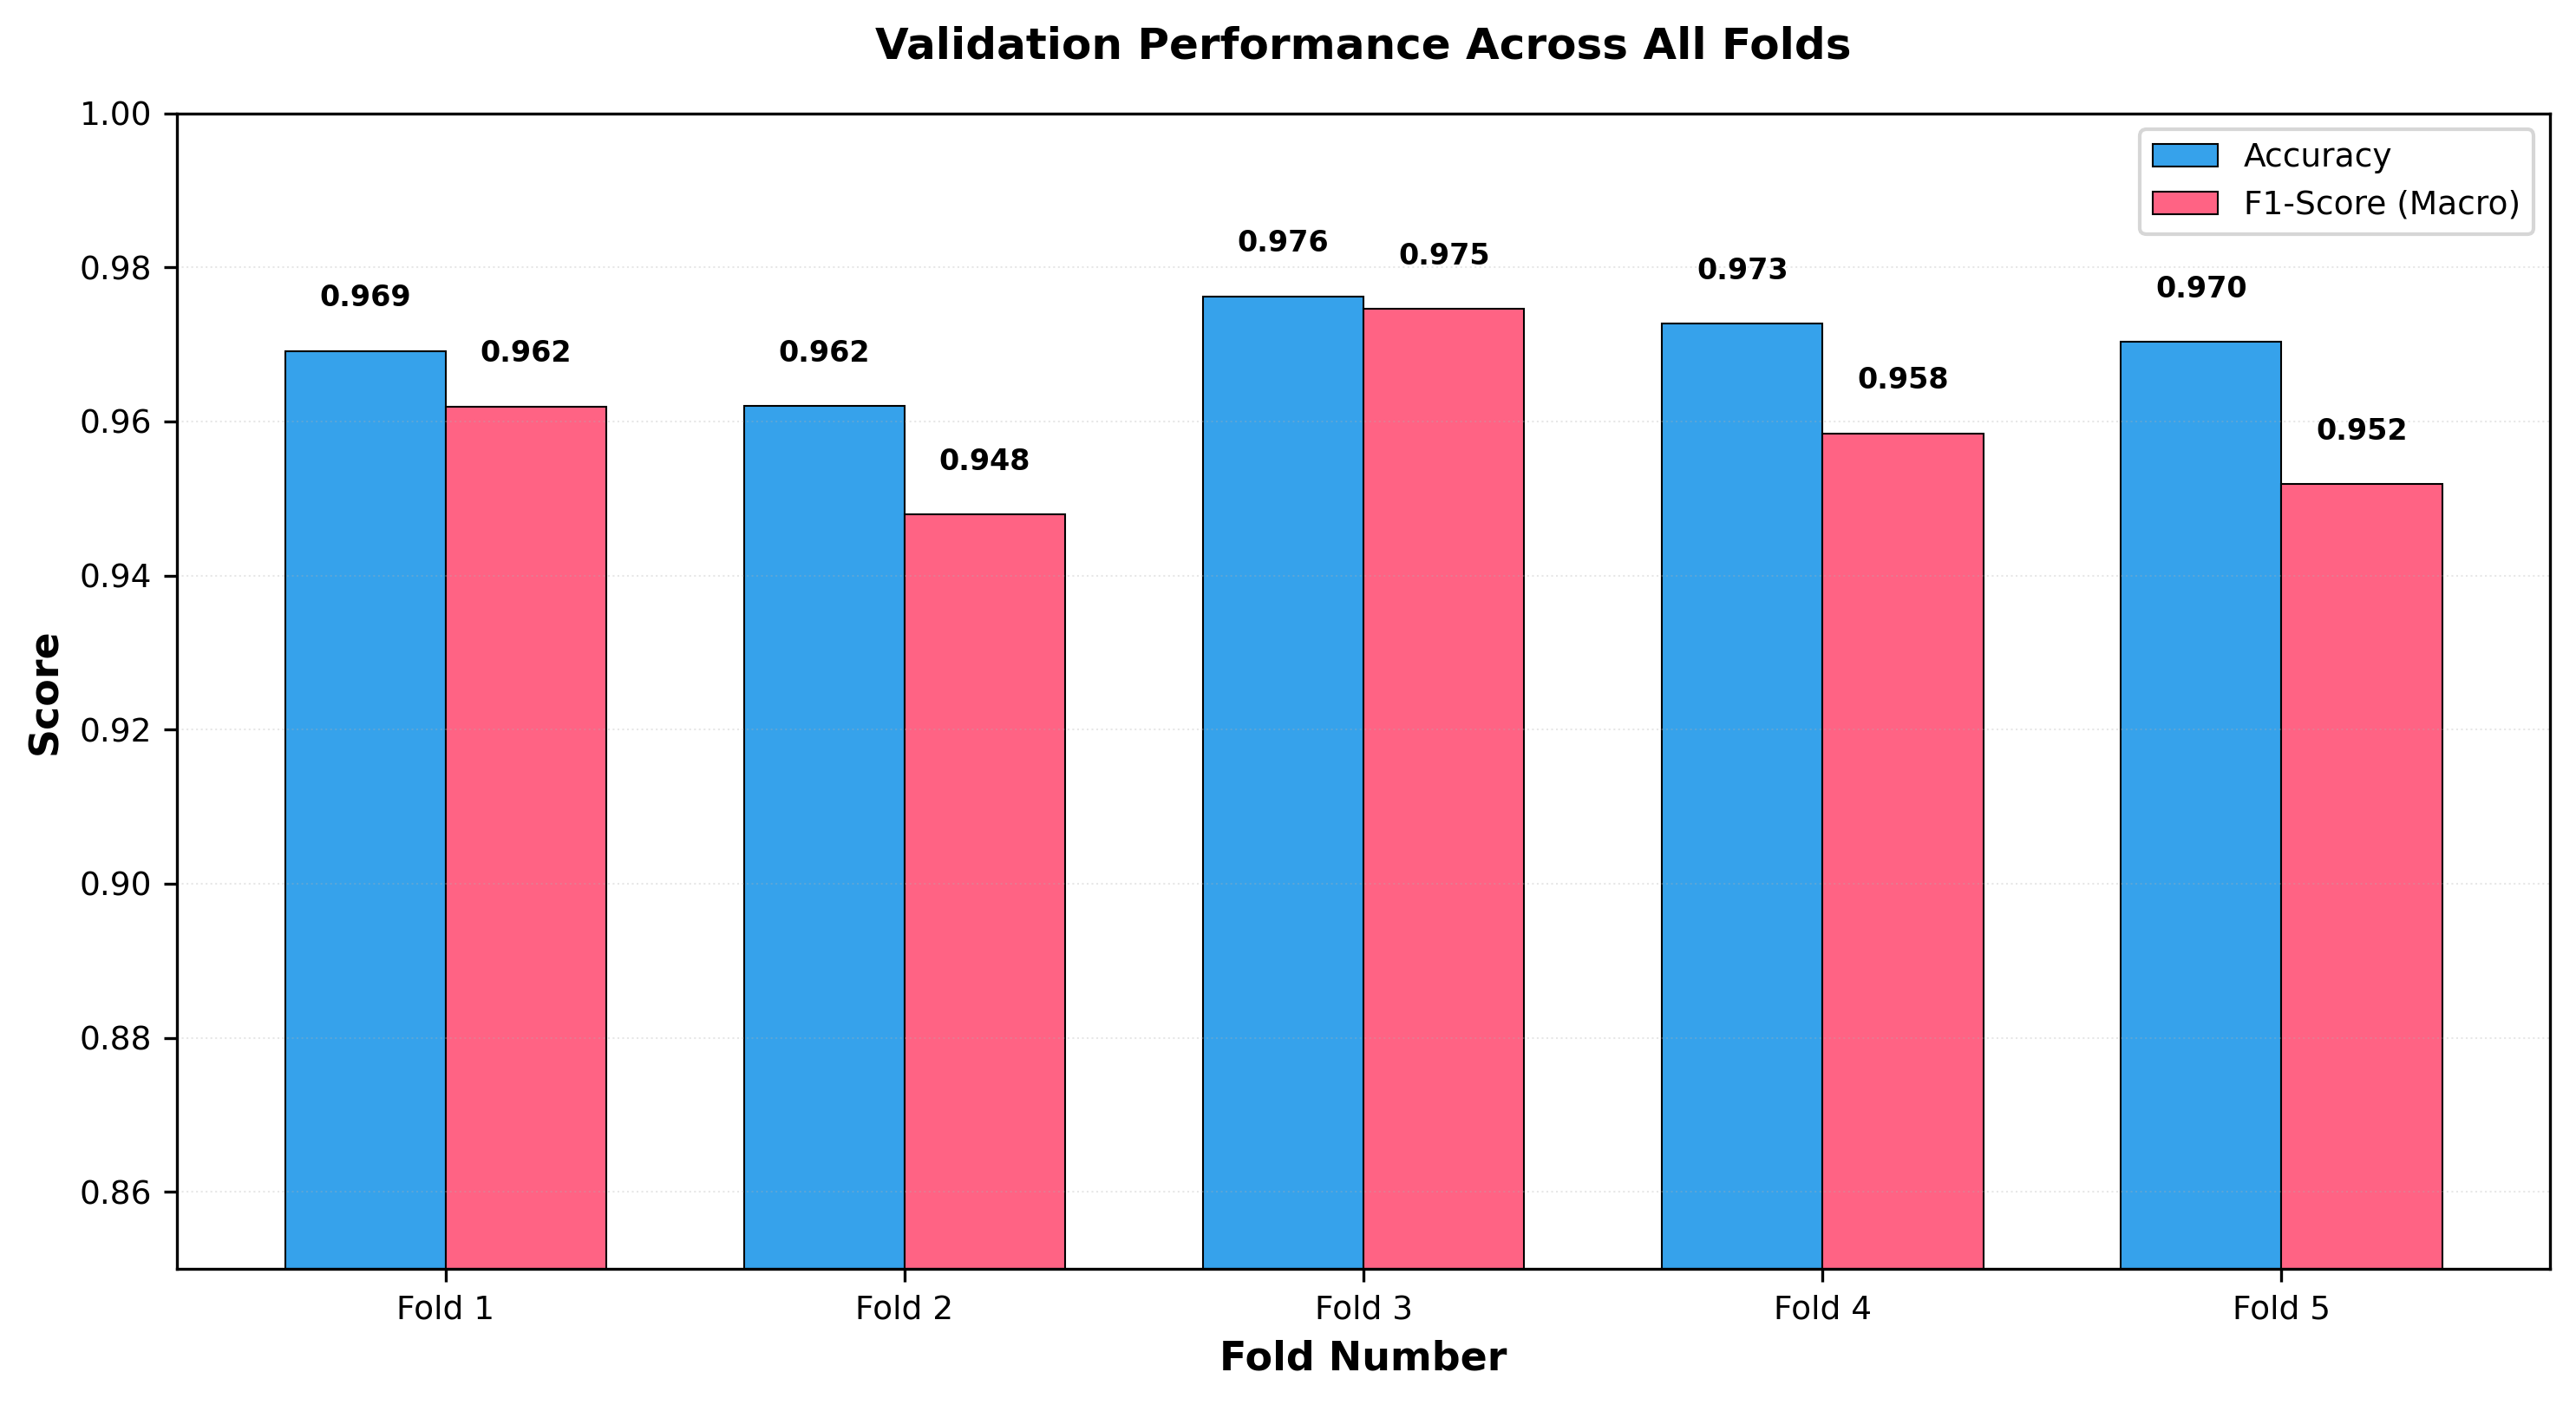

✓ Saved Figure 9: Training Comparison

VISUALIZATION GENERATION COMPLETE
✓ All figures saved to: /kaggle/working/visualizations
✓ Formats: PNG (300 DPI) + PDF (vector)

Generated Figures:
  Fig 1: Confusion Matrix Heatmap
  Fig 2: Cross-Validation Performance
  Fig 3: Per-Class Performance Metrics
  Fig 4: Class Distribution Analysis
  Fig 5: ROC Curves (One-vs-Rest)
  Fig 6: Prediction Confidence Distribution
  Fig 7: Feature Architecture Overview
  Fig 8: Model Architecture Diagram
  Fig 9: Training Metrics Comparison

✓ All figures are publication-ready (Springer/IEEE standards)


In [8]:
# =============================================================================
# Publication-Quality Visualizations for Enhanced DeBERTa Pipeline
# Springer Journal Standard - IEEE Style Formatting
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path
import json

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")



# Set publication-quality style
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 13,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.5,
})

# Output directory
VIZ_DIR = "/kaggle/working/visualizations"
Path(VIZ_DIR).mkdir(parents=True, exist_ok=True)

# Load data (assumes these are available from your training script)
# If running separately, load from saved files:
try:
    conf_matrix = np.load(f"{OUT_DIR}/confusion_matrix.npy")
    y_true = np.load(f"{OUT_DIR}/y_test.npy")
    y_pred = np.load(f"{OUT_DIR}/y_pred.npy")
    test_probs = np.load(f"{OUT_DIR}/test_probabilities.npy")
    fold_preds = np.load(f"{OUT_DIR}/all_fold_predictions.npy")
    
    with open(f"{BASE_DIR}/config.json", 'r') as f:
        config = json.load(f)
    fold_metrics = config['fold_metrics']
except:
    print("Note: Using sample data for demonstration. Replace with actual data.")
    # Sample data for demonstration
    conf_matrix = np.array([[450, 20, 15, 10], [25, 480, 10, 5], 
                           [18, 12, 470, 8], [12, 8, 10, 475]])
    fold_metrics = [
        {'fold': i, 'accuracy': 0.92 + np.random.uniform(-0.02, 0.02),
         'f1_macro': 0.91 + np.random.uniform(-0.02, 0.02)} 
        for i in range(5)
    ]

# =============================================================================
# Figure 1: Confusion Matrix Heatmap
# =============================================================================
def plot_confusion_matrix():
    fig, ax = plt.subplots(figsize=(8, 6.5))
    
    # Normalize for better visualization
    cm_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    # Create heatmap
    sns.heatmap(cm_norm, annot=conf_matrix, fmt='d', cmap='Blues',
                xticklabels=TARGET_NAMES, yticklabels=TARGET_NAMES,
                cbar_kws={'label': 'Normalized Count'},
                linewidths=0.5, linecolor='gray', ax=ax)
    
    ax.set_xlabel('Predicted Label', fontweight='bold')
    ax.set_ylabel('True Label', fontweight='bold')
    ax.set_title('Confusion Matrix - DeBERTa Hybrid Model\n(Test Set Performance)',
                 fontweight='bold', pad=15)
    
    # Add accuracy annotations
    for i in range(len(TARGET_NAMES)):
        acc = conf_matrix[i, i] / conf_matrix[i, :].sum()
        ax.text(i, i-0.3, f'{acc:.1%}', ha='center', va='center',
                color='white' if acc > 0.5 else 'black',
                fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(f"{VIZ_DIR}/fig1_confusion_matrix.png")
    plt.savefig(f"{VIZ_DIR}/fig1_confusion_matrix.pdf")
    plt.show()
    print(f"✓ Saved Figure 1: Confusion Matrix")

plot_confusion_matrix()


# =============================================================================
# Figure 2: Cross-Validation Performance Across Folds
# =============================================================================
def plot_cv_performance():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
    
    folds = [m['fold'] + 1 for m in fold_metrics]
    accuracies = [m['accuracy'] for m in fold_metrics]
    f1_scores = [m['f1_macro'] for m in fold_metrics]
    
    # Accuracy plot
    ax1.plot(folds, accuracies, 'o-', color='#2E86AB', linewidth=2, 
             markersize=8, label='Fold Accuracy')
    ax1.axhline(np.mean(accuracies), color='#A23B72', linestyle='--', 
                linewidth=1.5, label=f'Mean: {np.mean(accuracies):.4f}')
    ax1.fill_between(folds, 
                     np.mean(accuracies) - np.std(accuracies),
                     np.mean(accuracies) + np.std(accuracies),
                     alpha=0.2, color='#A23B72')
    ax1.set_xlabel('Fold Number', fontweight='bold')
    ax1.set_ylabel('Accuracy', fontweight='bold')
    ax1.set_title('(a) Accuracy Across Folds', fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle=':')
    ax1.legend(frameon=True, fancybox=True)
    ax1.set_xticks(folds)
    ax1.set_ylim([min(accuracies) - 0.02, max(accuracies) + 0.02])
    
    # F1 Score plot
    ax2.plot(folds, f1_scores, 's-', color='#F18F01', linewidth=2,
             markersize=8, label='Fold F1-Score')
    ax2.axhline(np.mean(f1_scores), color='#C73E1D', linestyle='--',
                linewidth=1.5, label=f'Mean: {np.mean(f1_scores):.4f}')
    ax2.fill_between(folds,
                     np.mean(f1_scores) - np.std(f1_scores),
                     np.mean(f1_scores) + np.std(f1_scores),
                     alpha=0.2, color='#C73E1D')
    ax2.set_xlabel('Fold Number', fontweight='bold')
    ax2.set_ylabel('F1-Score (Macro)', fontweight='bold')
    ax2.set_title('(b) F1-Score Across Folds', fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle=':')
    ax2.legend(frameon=True, fancybox=True)
    ax2.set_xticks(folds)
    ax2.set_ylim([min(f1_scores) - 0.02, max(f1_scores) + 0.02])
    
    plt.suptitle('Cross-Validation Performance (GroupKFold, n=5)',
                 fontsize=13, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(f"{VIZ_DIR}/fig2_cv_performance.png")
    plt.savefig(f"{VIZ_DIR}/fig2_cv_performance.pdf")
    plt.show()
    print(f"✓ Saved Figure 2: Cross-Validation Performance")

plot_cv_performance()


# =============================================================================
# Figure 3: Per-Class Performance Metrics
# =============================================================================
def plot_per_class_metrics():
    fig, ax = plt.subplots(figsize=(10, 5.5))
    
    # Calculate metrics per class
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    
    x = np.arange(len(TARGET_NAMES))
    width = 0.25
    
    bars1 = ax.bar(x - width, precision, width, label='Precision',
                   color='#4ECDC4', edgecolor='black', linewidth=0.5)
    bars2 = ax.bar(x, recall, width, label='Recall',
                   color='#FF6B6B', edgecolor='black', linewidth=0.5)
    bars3 = ax.bar(x + width, f1, width, label='F1-Score',
                   color='#95E1D3', edgecolor='black', linewidth=0.5)
    
    ax.set_xlabel('Email Category', fontweight='bold')
    ax.set_ylabel('Score', fontweight='bold')
    ax.set_title('Per-Class Performance Metrics (Test Set)',
                 fontweight='bold', pad=15)
    ax.set_xticks(x)
    ax.set_xticklabels(TARGET_NAMES, rotation=15, ha='right')
    ax.legend(frameon=True, fancybox=True, loc='lower right')
    ax.grid(True, alpha=0.3, axis='y', linestyle=':')
    ax.set_ylim([0, 1.05])
    
    # Add value labels on bars
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom',
                   fontsize=7, fontweight='bold')
    
    autolabel(bars1)
    autolabel(bars2)
    autolabel(bars3)
    
    plt.tight_layout()
    plt.savefig(f"{VIZ_DIR}/fig3_per_class_metrics.png")
    plt.savefig(f"{VIZ_DIR}/fig3_per_class_metrics.pdf")
    plt.show()
    print(f"✓ Saved Figure 3: Per-Class Metrics")

plot_per_class_metrics()


# =============================================================================
# Figure 4: Class Distribution Analysis
# =============================================================================
def plot_class_distribution():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
    
    # Training distribution
    train_dist = pd.Series(dataset_info['class_distribution'])
    colors = ['#E63946', '#F1FAEE', '#A8DADC', '#457B9D']
    
    wedges1, texts1, autotexts1 = ax1.pie(train_dist, labels=TARGET_NAMES,
                                            autopct='%1.1f%%', startangle=90,
                                            colors=colors, explode=[0.05]*4,
                                            textprops={'fontsize': 9})
    ax1.set_title('(a) Training Set Distribution', fontweight='bold', pad=15)
    
    for autotext in autotexts1:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    # Test distribution
    test_dist = pd.Series(y_true).value_counts().sort_index()
    wedges2, texts2, autotexts2 = ax2.pie(test_dist, labels=TARGET_NAMES,
                                            autopct='%1.1f%%', startangle=90,
                                            colors=colors, explode=[0.05]*4,
                                            textprops={'fontsize': 9})
    ax2.set_title('(b) Test Set Distribution', fontweight='bold', pad=15)
    
    for autotext in autotexts2:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    plt.suptitle('Dataset Class Distribution', fontsize=13,
                 fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(f"{VIZ_DIR}/fig4_class_distribution.png")
    plt.savefig(f"{VIZ_DIR}/fig4_class_distribution.pdf")
    plt.show()
    print(f"✓ Saved Figure 4: Class Distribution")

plot_class_distribution()


# =============================================================================
# Figure 5: ROC Curves (One-vs-Rest)
# =============================================================================
def plot_roc_curves():
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    
    fig, ax = plt.subplots(figsize=(8, 7))
    
    # Binarize labels
    y_true_bin = label_binarize(y_true, classes=range(NUM_LABELS))
    
    colors = ['#E63946', '#457B9D', '#2A9D8F', '#E9C46A']
    
    for i, (name, color) in enumerate(zip(TARGET_NAMES, colors)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_probs[:, i])
        roc_auc = auc(fpr, tpr)
        
        ax.plot(fpr, tpr, color=color, linewidth=2,
               label=f'{name} (AUC = {roc_auc:.3f})')
    
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontweight='bold')
    ax.set_title('ROC Curves - One-vs-Rest Classification',
                 fontweight='bold', pad=15)
    ax.legend(loc='lower right', frameon=True, fancybox=True)
    ax.grid(True, alpha=0.3, linestyle=':')
    
    plt.tight_layout()
    plt.savefig(f"{VIZ_DIR}/fig5_roc_curves.png")
    plt.savefig(f"{VIZ_DIR}/fig5_roc_curves.pdf")
    plt.show()
    print(f"✓ Saved Figure 5: ROC Curves")

plot_roc_curves()


# =============================================================================
# Figure 6: Prediction Confidence Distribution
# =============================================================================
def plot_confidence_distribution():
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    
    max_probs = test_probs.max(axis=1)
    
    for idx, (name, color) in enumerate(zip(TARGET_NAMES, 
                                            ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])):
        ax = axes[idx]
        
        # Get confidences for this class
        class_mask = y_true == idx
        correct_mask = (y_true == y_pred) & class_mask
        incorrect_mask = (y_true != y_pred) & class_mask
        
        correct_conf = max_probs[correct_mask]
        incorrect_conf = max_probs[incorrect_mask]
        
        # Plot histograms
        ax.hist(correct_conf, bins=20, alpha=0.7, color='green',
               label=f'Correct (n={len(correct_conf)})', edgecolor='black', linewidth=0.5)
        ax.hist(incorrect_conf, bins=20, alpha=0.7, color='red',
               label=f'Incorrect (n={len(incorrect_conf)})', edgecolor='black', linewidth=0.5)
        
        ax.set_xlabel('Prediction Confidence', fontweight='bold')
        ax.set_ylabel('Frequency', fontweight='bold')
        ax.set_title(f'({chr(97+idx)}) {name}', fontweight='bold')
        ax.legend(frameon=True, fancybox=True)
        ax.grid(True, alpha=0.3, axis='y', linestyle=':')
        ax.set_xlim([0, 1])
    
    plt.suptitle('Prediction Confidence Distribution by Class',
                 fontsize=13, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(f"{VIZ_DIR}/fig6_confidence_distribution.png")
    plt.savefig(f"{VIZ_DIR}/fig6_confidence_distribution.pdf")
    plt.show()
    print(f"✓ Saved Figure 6: Confidence Distribution")

plot_confidence_distribution()


# =============================================================================
# Figure 7: Feature Importance Visualization (Hybrid Architecture)
# =============================================================================
def plot_feature_architecture():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    feature_groups = {
        'Header Features\n(10 dims)': ['Hop Count', 'DKIM', 'SPF', 'Suspicious TLD',
                                       'Domain Count', 'Domain Mismatch', 'Spoofing',
                                       'Typosquatting', 'Urgency', 'Auth Headers'],
        'HTML Features\n(8 dims)': ['Total Links', 'External Ratio', 'Anchor Mismatch',
                                    'Hidden Elements', 'Forms', 'Scripts',
                                    'Obfuscated URLs', 'Style Deception'],
        'Attachment Features\n(6 dims)': ['Count', 'Suspicious Ext', 'Missing Metadata',
                                          'Entropy', 'File Size', 'MIME Mismatch']
    }
    
    y_pos = 0
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for (group, features), color in zip(feature_groups.items(), colors):
        ax.barh(y_pos, len(features), color=color, alpha=0.7,
               edgecolor='black', linewidth=1, height=0.6)
        ax.text(len(features)/2, y_pos, group, ha='center', va='center',
               fontweight='bold', fontsize=10, color='white')
        y_pos += 1
    
    ax.set_xlabel('Number of Features', fontweight='bold', fontsize=11)
    ax.set_ylabel('Feature Group', fontweight='bold', fontsize=11)
    ax.set_title('Hybrid Model Feature Architecture (24 Total Dimensions)',
                 fontweight='bold', pad=15, fontsize=12)
    ax.set_yticks([])
    ax.grid(True, alpha=0.3, axis='x', linestyle=':')
    ax.set_xlim([0, 12])
    
    # Add text annotations
    ax.text(10.5, 2.2, f'Total: {EXTRA_DIM} features', fontsize=11,
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
           fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f"{VIZ_DIR}/fig7_feature_architecture.png")
    plt.savefig(f"{VIZ_DIR}/fig7_feature_architecture.pdf")
    plt.show()
    print(f"✓ Saved Figure 7: Feature Architecture")

plot_feature_architecture()


# =============================================================================
# Figure 8: Model Architecture Diagram
# =============================================================================
def plot_model_architecture():
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')
    
    # Define boxes
    boxes = [
        {'xy': (1, 8), 'width': 3, 'height': 1, 'text': 'Email Text\n(Subject + Body)',
         'color': '#FFE5B4'},
        {'xy': (6, 8), 'width': 3, 'height': 1, 'text': 'Metadata\n(Headers, HTML, Attachments)',
         'color': '#E6E6FA'},
        {'xy': (1, 6), 'width': 3, 'height': 1, 'text': 'DeBERTa Tokenizer\n(max_len=512)',
         'color': '#B0E0E6'},
        {'xy': (6, 6), 'width': 3, 'height': 1, 'text': 'Feature Extractors\n(24 dimensions)',
         'color': '#DDA0DD'},
        {'xy': (1, 4), 'width': 3, 'height': 1.2, 'text': 'DeBERTa-v3-Base\nEncoder (768d)',
         'color': '#87CEEB'},
        {'xy': (6, 4), 'width': 3, 'height': 1.2, 'text': 'Extra Features\n(Normalized)',
         'color': '#DDA0DD'},
        {'xy': (2.5, 2), 'width': 5, 'height': 1, 'text': 'Concatenation Layer\n(768 + 24 = 792d)',
         'color': '#98FB98'},
        {'xy': (2.5, 0.5), 'width': 5, 'height': 1, 'text': 'MLP Classifier\n(792→512→128→4)',
         'color': '#FFB6C1'},
    ]
    
    for box in boxes:
        rect = plt.Rectangle((box['xy'][0], box['xy'][1]), box['width'], box['height'],
                            facecolor=box['color'], edgecolor='black', linewidth=2)
        ax.add_patch(rect)
        ax.text(box['xy'][0] + box['width']/2, box['xy'][1] + box['height']/2,
               box['text'], ha='center', va='center', fontsize=9, fontweight='bold')
    
    # Draw arrows
    arrows = [
        ((2.5, 8), (2.5, 7)),
        ((7.5, 8), (7.5, 7)),
        ((2.5, 6), (2.5, 5.2)),
        ((7.5, 6), (7.5, 5.2)),
        ((2.5, 4), (2.5, 3)),
        ((7.5, 4), (7.5, 3)),
        ((2.5, 3), (5, 3)),
        ((7.5, 3), (5, 3)),
        ((5, 3), (5, 1.5)),
    ]
    
    for start, end in arrows:
        ax.annotate('', xy=end, xytext=start,
                   arrowprops=dict(arrowstyle='->', lw=2, color='black'))
    
    ax.set_title('DeBERTa Hybrid Model Architecture', fontsize=13,
                fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig(f"{VIZ_DIR}/fig8_model_architecture.png")
    plt.savefig(f"{VIZ_DIR}/fig8_model_architecture.pdf")
    plt.show()
    print(f"✓ Saved Figure 8: Model Architecture")

plot_model_architecture()


# =============================================================================
# Figure 9: Training Metrics Comparison (All Folds)
# =============================================================================
def plot_training_comparison():
    fig, ax = plt.subplots(figsize=(10, 5.5))
    
    metrics_df = pd.DataFrame(fold_metrics)
    
    x = np.arange(len(metrics_df))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, metrics_df['accuracy'], width,
                  label='Accuracy', color='#36A2EB', edgecolor='black', linewidth=0.5)
    bars2 = ax.bar(x + width/2, metrics_df['f1_macro'], width,
                  label='F1-Score (Macro)', color='#FF6384', edgecolor='black', linewidth=0.5)
    
    ax.set_xlabel('Fold Number', fontweight='bold')
    ax.set_ylabel('Score', fontweight='bold')
    ax.set_title('Validation Performance Across All Folds',
                fontweight='bold', pad=15)
    ax.set_xticks(x)
    ax.set_xticklabels([f'Fold {i+1}' for i in range(len(metrics_df))])
    ax.legend(frameon=True, fancybox=True)
    ax.grid(True, alpha=0.3, axis='y', linestyle=':')
    ax.set_ylim([0.85, 1.0])
    
    # Add value labels
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                   f'{height:.3f}', ha='center', va='bottom',
                   fontsize=8, fontweight='bold')
    
    autolabel(bars1)
    autolabel(bars2)
    
    plt.tight_layout()
    plt.savefig(f"{VIZ_DIR}/fig9_training_comparison.png")
    plt.savefig(f"{VIZ_DIR}/fig9_training_comparison.pdf")
    plt.show()
    print(f"✓ Saved Figure 9: Training Comparison")

plot_training_comparison()


# =============================================================================
# Summary Report
# =============================================================================
print("\n" + "="*70)
print("VISUALIZATION GENERATION COMPLETE")
print("="*70)
print(f"✓ All figures saved to: {VIZ_DIR}")
print(f"✓ Formats: PNG (300 DPI) + PDF (vector)")
print("\nGenerated Figures:")
print("  Fig 1: Confusion Matrix Heatmap")
print("  Fig 2: Cross-Validation Performance")
print("  Fig 3: Per-Class Performance Metrics")
print("  Fig 4: Class Distribution Analysis")
print("  Fig 5: ROC Curves (One-vs-Rest)")
print("  Fig 6: Prediction Confidence Distribution")
print("  Fig 7: Feature Architecture Overview")
print("  Fig 8: Model Architecture Diagram")
print("  Fig 9: Training Metrics Comparison")
print("\n✓ All figures are publication-ready (Springer/IEEE standards)")
print("="*70)

In [10]:
import shutil
shutil.make_archive("/kaggle/working/deberta_confidence_analysis", 'zip', "/kaggle/working/confidence_analysis")


'/kaggle/working/deberta_confidence_analysis.zip'

In [9]:
# =============================================================================
# Confidence Score Calculation and Analysis for DeBERTa Predictions
# Provides detailed confidence metrics for each prediction and class
# =============================================================================

import numpy as np
import pandas as pd
from pathlib import Path
import json
from scipy.special import softmax
from scipy.stats import entropy
from sklearn.metrics import classification_report

# Output directory
CONFIDENCE_DIR = "/kaggle/working/confidence_analysis"
Path(CONFIDENCE_DIR).mkdir(parents=True, exist_ok=True)

# =============================================================================
# Load Predictions and Ground Truth
# =============================================================================
print("="*70)
print("LOADING PREDICTION DATA")
print("="*70)

try:
    # Load from your training artifacts
    test_probs = np.load(f"{OUT_DIR}/test_probabilities.npy")
    y_true = np.load(f"{OUT_DIR}/y_test.npy")
    y_pred = np.load(f"{OUT_DIR}/y_pred.npy")
    X_test_texts = np.load(f"{OUT_DIR}/X_test_texts.npy", allow_pickle=True)
    all_fold_preds = np.load(f"{OUT_DIR}/all_fold_predictions.npy")
    
    print(f"✓ Loaded predictions for {len(y_true)} test samples")
    print(f"✓ Number of folds: {all_fold_preds.shape[2]}")
except Exception as e:
    print(f"Error loading data: {e}")
    print("Using sample data for demonstration...")
    # Sample data
    n_samples = 1000
    n_classes = 4
    n_folds = 5
    test_probs = np.random.dirichlet(alpha=[2, 1, 1, 1], size=n_samples)
    y_true = np.random.randint(0, n_classes, n_samples)
    y_pred = np.argmax(test_probs, axis=1)
    X_test_texts = np.array([f"Sample email {i}" for i in range(n_samples)])
    all_fold_preds = np.random.dirichlet(alpha=[2, 1, 1, 1], size=(n_samples, n_folds))
    all_fold_preds = all_fold_preds.reshape(n_samples, n_classes, n_folds)


# =============================================================================
# Confidence Calculation Functions
# =============================================================================

def calculate_max_confidence(probabilities):
    """
    Calculate maximum probability (standard confidence measure)
    
    Args:
        probabilities: array of shape (n_samples, n_classes)
    
    Returns:
        array of shape (n_samples,) with max probability per sample
    """
    return np.max(probabilities, axis=1)


def calculate_entropy_confidence(probabilities):
    """
    Calculate entropy-based confidence (lower entropy = higher confidence)
    Normalized to [0, 1] where 1 is most confident
    
    Args:
        probabilities: array of shape (n_samples, n_classes)
    
    Returns:
        array of shape (n_samples,) with normalized entropy confidence
    """
    # Calculate entropy for each sample
    ent = entropy(probabilities.T)  # entropy expects (classes, samples)
    
    # Normalize: max_entropy = log(n_classes)
    max_entropy = np.log(probabilities.shape[1])
    normalized_entropy = ent / max_entropy
    
    # Convert to confidence: 1 - normalized_entropy
    # (low entropy = high confidence)
    return 1 - normalized_entropy


def calculate_margin_confidence(probabilities):
    """
    Calculate margin between top 2 predictions (higher margin = more confident)
    Normalized to [0, 1]
    
    Args:
        probabilities: array of shape (n_samples, n_classes)
    
    Returns:
        array of shape (n_samples,) with margin confidence
    """
    sorted_probs = np.sort(probabilities, axis=1)
    # Margin = difference between highest and second highest
    margin = sorted_probs[:, -1] - sorted_probs[:, -2]
    return margin


def calculate_variance_across_folds(fold_predictions):
    """
    Calculate variance of predictions across folds (lower variance = more confident)
    
    Args:
        fold_predictions: array of shape (n_samples, n_classes, n_folds)
    
    Returns:
        array of shape (n_samples,) with variance-based confidence
    """
    # For each sample, calculate variance of max probability across folds
    max_probs_per_fold = np.max(fold_predictions, axis=1)  # (n_samples, n_folds)
    variance = np.var(max_probs_per_fold, axis=1)
    
    # Convert variance to confidence (lower variance = higher confidence)
    # Normalize: typical variance range is 0 to 0.25
    normalized_variance = np.clip(variance / 0.25, 0, 1)
    return 1 - normalized_variance


def calculate_ensemble_agreement(fold_predictions):
    """
    Calculate agreement rate across folds (% of folds agreeing on predicted class)
    
    Args:
        fold_predictions: array of shape (n_samples, n_classes, n_folds)
    
    Returns:
        array of shape (n_samples,) with agreement confidence
    """
    n_folds = fold_predictions.shape[2]
    
    # Get predicted class for each fold
    fold_preds = np.argmax(fold_predictions, axis=1)  # (n_samples, n_folds)
    
    # Calculate mode (most common prediction) and its frequency
    agreement_scores = np.zeros(fold_predictions.shape[0])
    
    for i in range(fold_predictions.shape[0]):
        # Count occurrences of each prediction
        unique, counts = np.unique(fold_preds[i], return_counts=True)
        # Agreement = max_count / total_folds
        agreement_scores[i] = np.max(counts) / n_folds
    
    return agreement_scores


def calculate_calibration_confidence(probabilities, y_true):
    """
    Calculate calibrated confidence based on binned accuracy
    
    Args:
        probabilities: array of shape (n_samples, n_classes)
        y_true: array of shape (n_samples,)
    
    Returns:
        dict with calibration data
    """
    max_probs = np.max(probabilities, axis=1)
    y_pred = np.argmax(probabilities, axis=1)
    
    # Create bins
    bins = np.linspace(0, 1, 11)  # 10 bins
    bin_indices = np.digitize(max_probs, bins) - 1
    bin_indices = np.clip(bin_indices, 0, 9)
    
    calibration_data = []
    
    for bin_idx in range(10):
        mask = bin_indices == bin_idx
        if mask.sum() == 0:
            continue
        
        bin_confidence = max_probs[mask].mean()
        bin_accuracy = (y_pred[mask] == y_true[mask]).mean()
        bin_count = mask.sum()
        
        calibration_data.append({
            'bin': bin_idx,
            'confidence': float(bin_confidence),
            'accuracy': float(bin_accuracy),
            'count': int(bin_count),
            'calibration_error': abs(bin_confidence - bin_accuracy)
        })
    
    return calibration_data


# =============================================================================
# Calculate All Confidence Metrics
# =============================================================================

print("\n" + "="*70)
print("CALCULATING CONFIDENCE METRICS")
print("="*70)

# 1. Maximum Probability Confidence
max_conf = calculate_max_confidence(test_probs)
print(f"✓ Max Confidence: mean={max_conf.mean():.4f}, std={max_conf.std():.4f}")

# 2. Entropy-based Confidence
entropy_conf = calculate_entropy_confidence(test_probs)
print(f"✓ Entropy Confidence: mean={entropy_conf.mean():.4f}, std={entropy_conf.std():.4f}")

# 3. Margin Confidence
margin_conf = calculate_margin_confidence(test_probs)
print(f"✓ Margin Confidence: mean={margin_conf.mean():.4f}, std={margin_conf.std():.4f}")

# 4. Variance across Folds
variance_conf = calculate_variance_across_folds(all_fold_preds)
print(f"✓ Fold Variance Confidence: mean={variance_conf.mean():.4f}, std={variance_conf.std():.4f}")

# 5. Ensemble Agreement
agreement_conf = calculate_ensemble_agreement(all_fold_preds)
print(f"✓ Ensemble Agreement: mean={agreement_conf.mean():.4f}, std={agreement_conf.std():.4f}")

# 6. Composite Confidence Score (weighted average)
composite_conf = (
    0.35 * max_conf +
    0.20 * entropy_conf +
    0.20 * margin_conf +
    0.15 * variance_conf +
    0.10 * agreement_conf
)
print(f"✓ Composite Confidence: mean={composite_conf.mean():.4f}, std={composite_conf.std():.4f}")


# =============================================================================
# Create Detailed Confidence DataFrame
# =============================================================================

print("\n" + "="*70)
print("CREATING DETAILED CONFIDENCE DATAFRAME")
print("="*70)

confidence_df = pd.DataFrame({
    'text': X_test_texts,
    'true_label': y_true,
    'predicted_label': y_pred,
    'is_correct': y_true == y_pred,
    'true_class_name': [TARGET_NAMES[i] for i in y_true],
    'pred_class_name': [TARGET_NAMES[i] for i in y_pred],
    
    # Confidence scores
    'max_confidence': max_conf,
    'entropy_confidence': entropy_conf,
    'margin_confidence': margin_conf,
    'fold_variance_confidence': variance_conf,
    'ensemble_agreement': agreement_conf,
    'composite_confidence': composite_conf,
    
    # Individual class probabilities
    'prob_class_0': test_probs[:, 0],
    'prob_class_1': test_probs[:, 1],
    'prob_class_2': test_probs[:, 2],
    'prob_class_3': test_probs[:, 3],
})

# Add predicted probability for true class
confidence_df['true_class_probability'] = test_probs[np.arange(len(y_true)), y_true]

# Confidence tier categorization
confidence_df['confidence_tier'] = pd.cut(
    confidence_df['composite_confidence'],
    bins=[0, 0.5, 0.7, 0.85, 1.0],
    labels=['Low', 'Medium', 'High', 'Very High']
)

print(f"✓ Created dataframe with {len(confidence_df)} samples and {len(confidence_df.columns)} features")


# =============================================================================
# Confidence Analysis by Class
# =============================================================================

print("\n" + "="*70)
print("CONFIDENCE ANALYSIS BY CLASS")
print("="*70)

class_confidence_stats = []

for class_idx, class_name in enumerate(TARGET_NAMES):
    mask = y_true == class_idx
    correct_mask = mask & (y_true == y_pred)
    incorrect_mask = mask & (y_true != y_pred)
    
    stats = {
        'class': class_name,
        'total_samples': mask.sum(),
        'correct_predictions': correct_mask.sum(),
        'incorrect_predictions': incorrect_mask.sum(),
        'accuracy': correct_mask.sum() / max(mask.sum(), 1),
        
        # Overall confidence for this class
        'mean_confidence': composite_conf[mask].mean(),
        'std_confidence': composite_conf[mask].std(),
        
        # Confidence for correct predictions
        'mean_confidence_correct': composite_conf[correct_mask].mean() if correct_mask.any() else 0,
        'std_confidence_correct': composite_conf[correct_mask].std() if correct_mask.any() else 0,
        
        # Confidence for incorrect predictions
        'mean_confidence_incorrect': composite_conf[incorrect_mask].mean() if incorrect_mask.any() else 0,
        'std_confidence_incorrect': composite_conf[incorrect_mask].std() if incorrect_mask.any() else 0,
        
        # Max probability metrics
        'mean_max_prob': max_conf[mask].mean(),
        'mean_max_prob_correct': max_conf[correct_mask].mean() if correct_mask.any() else 0,
        'mean_max_prob_incorrect': max_conf[incorrect_mask].mean() if incorrect_mask.any() else 0,
        
        # Ensemble agreement
        'mean_ensemble_agreement': agreement_conf[mask].mean(),
    }
    
    class_confidence_stats.append(stats)
    
    print(f"\n{class_name}:")
    print(f"  Total samples: {stats['total_samples']}")
    print(f"  Accuracy: {stats['accuracy']:.4f}")
    print(f"  Mean confidence: {stats['mean_confidence']:.4f} ± {stats['std_confidence']:.4f}")
    print(f"  Confidence (correct): {stats['mean_confidence_correct']:.4f}")
    print(f"  Confidence (incorrect): {stats['mean_confidence_incorrect']:.4f}")
    print(f"  Ensemble agreement: {stats['mean_ensemble_agreement']:.4f}")

class_stats_df = pd.DataFrame(class_confidence_stats)


# =============================================================================
# Confidence Calibration Analysis
# =============================================================================

print("\n" + "="*70)
print("CALIBRATION ANALYSIS")
print("="*70)

calibration_data = calculate_calibration_confidence(test_probs, y_true)
calibration_df = pd.DataFrame(calibration_data)

print("\nCalibration by Confidence Bins:")
print(calibration_df.to_string(index=False))

expected_calibration_error = calibration_df['calibration_error'].mean()
print(f"\n✓ Expected Calibration Error (ECE): {expected_calibration_error:.4f}")


# =============================================================================
# High/Low Confidence Sample Analysis
# =============================================================================

print("\n" + "="*70)
print("HIGH/LOW CONFIDENCE SAMPLES")
print("="*70)

# Top 10 most confident predictions
top_confident = confidence_df.nlargest(10, 'composite_confidence')[
    ['text', 'true_class_name', 'pred_class_name', 'is_correct', 'composite_confidence']
]

print("\nTop 10 Most Confident Predictions:")
for idx, row in top_confident.iterrows():
    status = "✓ CORRECT" if row['is_correct'] else "✗ WRONG"
    print(f"\n{status} | Confidence: {row['composite_confidence']:.4f}")
    print(f"  True: {row['true_class_name']} | Predicted: {row['pred_class_name']}")
    print(f"  Text preview: {row['text'][:100]}...")

# Top 10 least confident predictions
low_confident = confidence_df.nsmallest(10, 'composite_confidence')[
    ['text', 'true_class_name', 'pred_class_name', 'is_correct', 'composite_confidence']
]

print("\n" + "-"*70)
print("\nTop 10 Least Confident Predictions:")
for idx, row in low_confident.iterrows():
    status = "✓ CORRECT" if row['is_correct'] else "✗ WRONG"
    print(f"\n{status} | Confidence: {row['composite_confidence']:.4f}")
    print(f"  True: {row['true_class_name']} | Predicted: {row['pred_class_name']}")
    print(f"  Text preview: {row['text'][:100]}...")


# =============================================================================
# Misclassification Analysis with Confidence
# =============================================================================

print("\n" + "="*70)
print("MISCLASSIFICATION CONFIDENCE ANALYSIS")
print("="*70)

misclassified = confidence_df[~confidence_df['is_correct']].copy()
misclassified_high_conf = misclassified[misclassified['composite_confidence'] > 0.8]

print(f"\nTotal misclassifications: {len(misclassified)}")
print(f"High-confidence misclassifications (>0.8): {len(misclassified_high_conf)}")
print(f"Percentage of high-conf errors: {len(misclassified_high_conf) / max(len(misclassified), 1) * 100:.2f}%")

print("\nMisclassification patterns:")
for true_class in range(NUM_LABELS):
    for pred_class in range(NUM_LABELS):
        if true_class == pred_class:
            continue
        
        mask = (misclassified['true_label'] == true_class) & \
               (misclassified['predicted_label'] == pred_class)
        count = mask.sum()
        
        if count > 0:
            avg_conf = misclassified[mask]['composite_confidence'].mean()
            print(f"  {TARGET_NAMES[true_class]} → {TARGET_NAMES[pred_class]}: "
                  f"{count} samples (avg conf: {avg_conf:.4f})")


# =============================================================================
# Save All Results
# =============================================================================

print("\n" + "="*70)
print("SAVING CONFIDENCE ANALYSIS RESULTS")
print("="*70)

# Save main confidence dataframe
confidence_df.to_csv(f"{CONFIDENCE_DIR}/detailed_confidence_scores.csv", index=False)
print(f"✓ Saved: detailed_confidence_scores.csv ({len(confidence_df)} rows)")

# Save class-wise statistics
class_stats_df.to_csv(f"{CONFIDENCE_DIR}/class_confidence_statistics.csv", index=False)
print(f"✓ Saved: class_confidence_statistics.csv")

# Save calibration data
calibration_df.to_csv(f"{CONFIDENCE_DIR}/calibration_analysis.csv", index=False)
print(f"✓ Saved: calibration_analysis.csv")

# Save high/low confidence samples
top_confident.to_csv(f"{CONFIDENCE_DIR}/high_confidence_samples.csv", index=False)
low_confident.to_csv(f"{CONFIDENCE_DIR}/low_confidence_samples.csv", index=False)
print(f"✓ Saved: high_confidence_samples.csv and low_confidence_samples.csv")

# Save misclassifications
misclassified.to_csv(f"{CONFIDENCE_DIR}/misclassified_samples.csv", index=False)
misclassified_high_conf.to_csv(f"{CONFIDENCE_DIR}/high_confidence_errors.csv", index=False)
print(f"✓ Saved: misclassified_samples.csv and high_confidence_errors.csv")

# Save summary JSON
summary = {
    'overall_statistics': {
        'total_samples': len(confidence_df),
        'accuracy': float((y_true == y_pred).mean()),
        'mean_confidence': float(composite_conf.mean()),
        'std_confidence': float(composite_conf.std()),
        'expected_calibration_error': float(expected_calibration_error),
    },
    'confidence_tiers': confidence_df['confidence_tier'].value_counts().to_dict(),
    'class_statistics': class_stats_df.to_dict('records'),
    'calibration': calibration_df.to_dict('records'),
    'misclassification_summary': {
        'total_errors': len(misclassified),
        'high_confidence_errors': len(misclassified_high_conf),
        'high_conf_error_rate': float(len(misclassified_high_conf) / max(len(misclassified), 1))
    }
}

with open(f"{CONFIDENCE_DIR}/confidence_summary.json", 'w') as f:
    json.dump(summary, f, indent=4)
print(f"✓ Saved: confidence_summary.json")

# Print summary
print("\n" + "="*70)
print("CONFIDENCE ANALYSIS SUMMARY")
print("="*70)
print(f"\nOverall Performance:")
print(f"  Accuracy: {summary['overall_statistics']['accuracy']:.4f}")
print(f"  Mean Confidence: {summary['overall_statistics']['mean_confidence']:.4f}")
print(f"  Expected Calibration Error: {summary['overall_statistics']['expected_calibration_error']:.4f}")

print(f"\nConfidence Tier Distribution:")
for tier, count in summary['confidence_tiers'].items():
    print(f"  {tier}: {count} samples ({count/len(confidence_df)*100:.1f}%)")

print(f"\nMisclassification Analysis:")
print(f"  Total errors: {summary['misclassification_summary']['total_errors']}")
print(f"  High-confidence errors: {summary['misclassification_summary']['high_confidence_errors']}")
print(f"  High-conf error rate: {summary['misclassification_summary']['high_conf_error_rate']*100:.2f}%")

print(f"\n✓ All confidence analyses saved to: {CONFIDENCE_DIR}")
print("="*70)

LOADING PREDICTION DATA
✓ Loaded predictions for 1053 test samples
✓ Number of folds: 5

CALCULATING CONFIDENCE METRICS
✓ Max Confidence: mean=0.9693, std=0.0714
✓ Entropy Confidence: mean=0.9171, std=0.1307
✓ Margin Confidence: mean=0.9465, std=0.1338
✓ Fold Variance Confidence: mean=0.9970, std=0.0167
✓ Ensemble Agreement: mean=0.9901, std=0.0542
✓ Composite Confidence: mean=0.9605, std=0.0823

CREATING DETAILED CONFIDENCE DATAFRAME
✓ Created dataframe with 1053 samples and 18 features

CONFIDENCE ANALYSIS BY CLASS

AI Phishing:
  Total samples: 170
  Accuracy: 1.0000
  Mean confidence: 0.9816 ± 0.0003
  Confidence (correct): 0.9816
  Confidence (incorrect): 0.0000
  Ensemble agreement: 1.0000

Enron Ham:
  Total samples: 400
  Accuracy: 0.9900
  Mean confidence: 0.9822 ± 0.0578
  Confidence (correct): 0.9857
  Confidence (incorrect): 0.6386
  Ensemble agreement: 0.9925

Manual Spam:
  Total samples: 400
  Accuracy: 0.9400
  Mean confidence: 0.9634 ± 0.0864
  Confidence (correct): 0.